This focuses on

1. Variable Identification
2. Univarient Analysis
3. Bi-varient Analysis for Hemoglobin levels and anemia status
4. Multi-varient Analysis for Hemoglobin levels and anemia status

In [134]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import describe, skew, kurtosis
!pip install imblearn
from sklearn.decomposition import PCA
from boostaroota import BoostARoota
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import catboost as cat_
from sklearn.metrics import accuracy_score
# import lightgbm as lgb
import xgboost as xgb
%matplotlib inline

In [135]:
individual_recode = pd.read_csv('./individual_house_hold_recode.csv')

In [136]:
individual_recode.head()

,Unnamed: 0,HHID Case Identification,HV000 Country code and phase,HV001 Cluster number,HV002 Household number,HV003 Respondent's line number (answering Household questionnaire),HV004 Ultimate area unit,HV005 Household sample weight (6 decimals),HV006 Month of interview,HV007 Year of interview,...,HML37F$01 Suffer from illnesssymptom: abnormal bleeding,HML37G$01 Suffer from illnesssymptom: jaundice or yellow skin,HML37H$01 Suffer from illnesssymptom: dark urine,HML37I$01 Suffer from illnesssymptom: vomiting,HML37J$01 Suffer from illnesssymptom: pallor,HML37K$01 Suffer from illnesssymptom: refusal to eat,HML37L$01 Suffer from illnesssymptom: very cold hands and feet,HML38$01 Child taken or taking first line medicine given by health provider for malaria,HML39$01 Parent accept first line medicine to treat malaria,HML40$01 Fieldworker provided first line medicine for malaria
0,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1 1,NG8,1.0,1.0,3.0,1.0,1119345.0,10.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
for cols in individual_recode.columns:
    print(cols)

Unnamed: 0
HHID     Case Identification
HV000    Country code and phase
HV001    Cluster number
HV002    Household number
HV003    Respondent's line number (answering Household questionnaire)
HV004    Ultimate area unit
HV005    Household sample weight (6 decimals)
HV006    Month of interview
HV007    Year of interview
HV008    Date of interview (CMC)
HV008A   Date of interview Century Day Code (CDC)
HV009    Number of household members
HV010    Number of eligible women in household
HV012    Number of de jure members
HV013    Number of de facto members
HV014    Number of children 5 and under (de jure)
HV015    Result of household interview
HV016    Day of interview
HV017    Number of visits
HV018    Interviewer identification
HV020    Ever-married sample
HV021    Primary sampling unit
HV022    Sample strata for sampling errors
HV023    Stratification used in sample design
HV024    Region
HV025    Type of place of residence
HV027    Household selected for male interview
HV028    Househo

In [138]:
individual_recode.dropna(subset=['HV105$01 Age of household members'], inplace=True)

In [139]:
individual_recode.shape

(70428, 260)

In [140]:
individual_recode['HV105$01 Age of household members'].head()

0    50.0
1     7.0
2    11.0
3    16.0
4    37.0
Name: HV105$01 Age of household members, dtype: object

In [141]:
children_under_5 = copy.deepcopy(individual_recode)

In [142]:
non_int_mask = children_under_5['HV105$01 Age of household members'].apply(lambda x: not isinstance(x, int))

In [143]:
# Convert the column to numeric, treating non-convertible values as NaN
children_under_5['HV105$01 Age of household members'] = pd.to_numeric(
    children_under_5['HV105$01 Age of household members'], errors='coerce')
# children_under_5 = children_under_5[children_under_5['HV105$01 Age of household members'] != "Don't know"]
#
# children_under_5 = children_under_5[children_under_5['HV105$01 Age of household members'] != '95+']
# children_under_5['HV105$01 Age of household members'] = children_under_5['HV105$01 Age of household members'].astype(float)

In [144]:
def to_number(value):
    if not isinstance(value, (int, float)):
        return None
    return float(value)

In [145]:
children_under_5 = children_under_5[children_under_5['HV105$01 Age of household members'].apply(to_number) <= 60]

In [146]:
children_under_5['HV105$01 Age of household members'].isnull().sum()

0

In [147]:
children_under_5['HML32$01 Final result of malaria from blood smear test'].isnull().sum()

56268

In [148]:
children_under_5['HML32$01 Final result of malaria from blood smear test'].describe()

count        10655
unique           2
top       Negative
freq          8390
Name: HML32$01 Final result of malaria from blood smear test, dtype: object

In [149]:
children_under_5['HML32$01 Final result of malaria from blood smear test'].value_counts()

HML32$01 Final result of malaria from blood smear test
Negative    8390
Positive    2265
Name: count, dtype: int64

In [150]:
print(2265/(8390+2265))

0.21257625527921165


In [151]:
children_under_5.dropna(subset=['HML32$01 Final result of malaria from blood smear test'], inplace=True)

In [152]:
children_under_5.drop('row_key', axis=1, inplace=True)

In [153]:
children_under_5.shape

(10655, 259)

In [154]:
for cols in children_under_5.columns:
    print(cols)

Unnamed: 0
HHID     Case Identification
HV000    Country code and phase
HV001    Cluster number
HV002    Household number
HV003    Respondent's line number (answering Household questionnaire)
HV004    Ultimate area unit
HV005    Household sample weight (6 decimals)
HV006    Month of interview
HV007    Year of interview
HV008    Date of interview (CMC)
HV008A   Date of interview Century Day Code (CDC)
HV009    Number of household members
HV010    Number of eligible women in household
HV012    Number of de jure members
HV013    Number of de facto members
HV014    Number of children 5 and under (de jure)
HV015    Result of household interview
HV016    Day of interview
HV017    Number of visits
HV018    Interviewer identification
HV020    Ever-married sample
HV021    Primary sampling unit
HV022    Sample strata for sampling errors
HV023    Stratification used in sample design
HV024    Region
HV025    Type of place of residence
HV027    Household selected for male interview
HV028    Househo

In [155]:

household_Information = [
    'HV004    Ultimate area unit',
    'HV009    Number of household members', 'HV010    Number of eligible women in household',
    'HV012    Number of de jure members', 'HV013    Number of de facto members',
    'HV014    Number of children 5 and under (de jure)', 
]
household_characteristics = [
    'HV204    Time to get to water source (minutes)', 'HV205    Type of toilet facility', 'HV206    Has electricity',
    'HV207    Has radio', 'HV208    Has television', 'HV209    Has refrigerator', 'HV210    Has bicycle',
    'HV211    Has motorcyclescooter', 'HV212    Has cartruck', 'HV213    Main floor material',
    'HV214    Main wall material', 'HV215    Main roof material', 'HV216    Number of rooms used for sleeping',
    'HV219    Sex of head of household', 'HV220    Age of head of household',
    'HV221    Has telephone (land-line)', 'HV222    Type of cookstove', 'HV225    Share toilet with other households',
    'HV227    Has mosquito bed net for sleeping', 'HV228    Children under 5 slept under mosquito bed net last night',
    'HV235    Location of source for water', 'HV238    Number of households sharing toilet',
    'HV244    Owns land usable for agriculture', 'HV245    Hectares of agricultural land (1 decimal)',
    'HV246    Owns livestock, herds or farm animals', 'HV247    Has bank account', 'HV270    Wealth index combined',
    'HV222    Type of cookstove', 'HV227    Has mosquito bed net for sleeping',
    'HV228    Children under 5 slept under mosquito bed net last night', 'HV238    Number of households sharing toilet',
    'HV245    Hectares of agricultural land (1 decimal)', 'HV246    Owns livestock, herds or farm animals',
    'HV246A   Owns cattle', 'HV246B   Owns cows bulls', 'HV246C   Owns horses donkeys mules', 'HV246D   Owns goats',
    'HV246E   Owns sheep', 'HV246F   Owns chickenspoultry', 'HV246G   Owns pigs', 'HV246H   Owns camels'
]


bed_net_usage_and_malaria = [
    'HML1     Number of mosquito bed nets'
]

socio_economic_factors = household_Information + household_characteristics + bed_net_usage_and_malaria
#removing duplicates
socio_economic_factors = sorted(set(socio_economic_factors))


In [156]:
children_under_5[socio_economic_factors].head()

,HML1 Number of mosquito bed nets,HV004 Ultimate area unit,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV204 Time to get to water source (minutes),HV205 Type of toilet facility,HV206 Has electricity,...,HV246A Owns cattle,HV246B Owns cows bulls,HV246C Owns horses donkeys mules,HV246D Owns goats,HV246E Owns sheep,HV246F Owns chickenspoultry,HV246G Owns pigs,HV246H Owns camels,HV247 Has bank account,HV270 Wealth index combined
9,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
10,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
13,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
21,2.0,1.0,6.0,2.0,6.0,6.0,1.0,On premises,Flush to septic tank,No,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,Yes,Middle
31,1.0,1.0,9.0,2.0,9.0,9.0,2.0,On premises,Flush to septic tank,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Middle


In [157]:
demographic_factors = [
    'HV009    Number of household members', 'HV010    Number of eligible women in household',
    'HV012    Number of de jure members', 'HV013    Number of de facto members',
    'HV014    Number of children 5 and under (de jure)',
    'HV220    Age of head of household',
    'HV219    Sex of head of household'
]
demographic_factors = sorted(set(demographic_factors))

In [158]:
_cols_num_str = ['HV220    Age of head of household','HV238    Number of households sharing toilet','HV245    Hectares of agricultural land (1 decimal)', 'HV246A   Owns cattle', 'HV246B   Owns cows bulls', 'HV246C   Owns horses donkeys mules','HV246D   Owns goats','HV246E   Owns sheep', 'HV246F   Owns chickenspoultry', 'HV246G   Owns pigs', 'HV246H   Owns camels']

for col in _cols_num_str:
    children_under_5[col] = children_under_5[col].apply(to_number)

 # ** Social Economic Univariate Analysis

In [159]:
_socio_economic_data = children_under_5[socio_economic_factors]
# for col in _socio_economic_data:
#     if _socio_economic_data[col].dtype == "object":
#             _socio_economic_data[col] = LabelEncoder().fit_transform(_socio_economic_data[col])

In [160]:
def calculate_central_tendency_and_dispersion(data):
    """
    Calculates the central tendency and dispersion of a given dataset.

    Parameters:
        data (list or numpy array): The dataset for which to calculate central tendency and dispersion.

    Returns:
        dict: A dictionary containing the following statistics:
              - Mean
              - Median
              - Mode (if exists)
              - Variance
              - Standard Deviation
    """
    # Convert the data to a numpy array for easy calculations
    data = np.array(data)

    # Calculate central tendency
    mean = np.mean(data)
    median = np.median(data)

    # Calculate mode
    mode_result = stats.mode(data)
    mode = mode_result.mode[0] if len(mode_result.mode) > 0 else None

    # Calculate dispersion
    variance = np.var(data, ddof=0)  # Set ddof=0 for population variance, ddof=1 for sample variance
    std_deviation = np.std(data, ddof=0)  # Set ddof=0 for population std deviation, ddof=1 for sample std deviation
    kurtosis_value = kurtosis(data, axis=0, bias=True)
    screw_value = skew(data, axis=0, bias=True)
    # Create a dictionary to store the results
    statistics = {
        'Mean': mean,
        'Median': median,
        'Mode': mode,
        'Variance': variance,
        'Standard Deviation': std_deviation,
        'Kurtosis': kurtosis_value,
        'Screw': screw_value
    }

    print('Data set description')
    print(describe(data, axis=0))

    return statistics

In [161]:
def feature_uni_varaite_analysis(name,_data):
    try:
        print('Feature Name: ', name)
        print('Number of Unique Values: ', _data[name].nunique())
        if _data[name].nunique() < 8:
            print('Unique Values: ', _data[name].unique())
            print('Value Counts: ', _data[name].value_counts())
            _data[name].value_counts().plot(kind='bar')
            plt.show()
        print('Central Tendency and Dispersion: ',calculate_central_tendency_and_dispersion(_data[name]))
        print('Plotting the count plot')
        if _data[name].nunique() < 8:
            sns.countplot(data=_data, x=name)
            plt.show()
            plt.pie(_data[name].value_counts(), labels=_data[name].unique(), autopct='%1.1f%%')
            plt.show()
        else:
            sns.histplot(data=_data, x=name, bins=20)
            plt.show()
            sns.kdeplot(data=_data, x=name)
            plt.show()
            sns.boxplot(data=_data, x=name)
            plt.show()
            sns.violinplot(data=_data, x=name)
            plt.show()
    except:
        print('Error in feature: ', name)
        pass


 # Univariate Analysis

Feature Name:  HML1     Number of mosquito bed nets
Number of Unique Values:  8
Data set description
DescribeResult(nobs=10655, minmax=(0.0, 7.0), mean=1.6870952604411074, variance=3.3924137036146664, skewness=1.1249232170390968, kurtosis=0.712597593098411)
Central Tendency and Dispersion:  {'Mean': 1.6870952604411074, 'Median': 1.0, 'Mode': 0.0, 'Variance': 3.3920953165941485, 'Standard Deviation': 1.8417641859353624, 'Kurtosis': 0.712597593098411, 'Screw': 1.1249232170390968}
Plotting the count plot


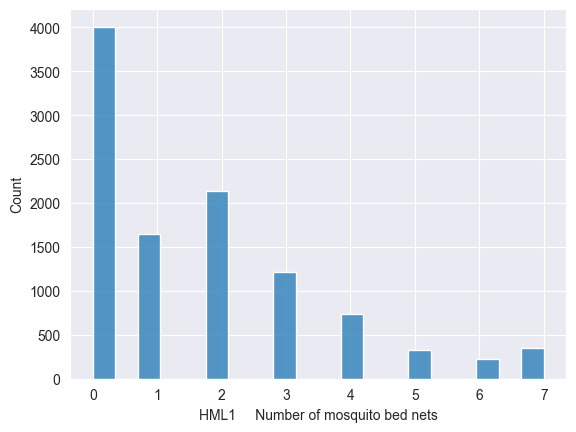

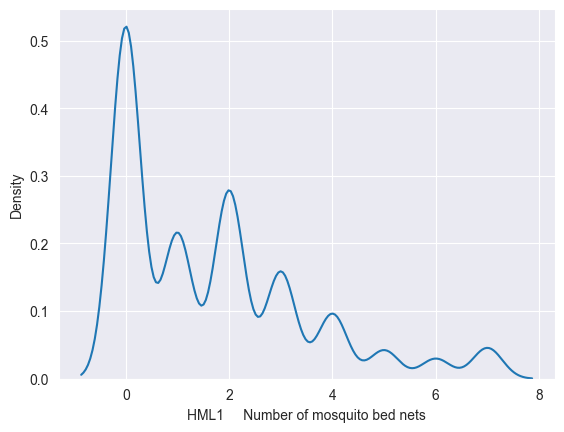

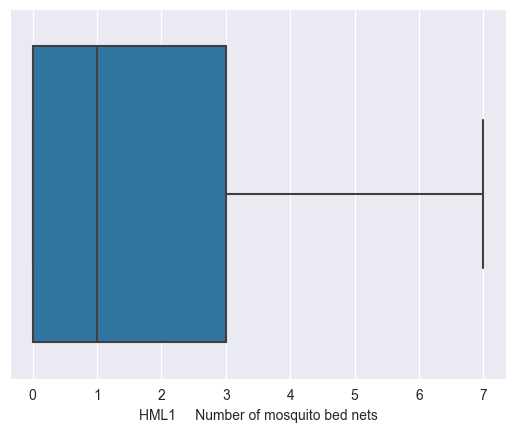

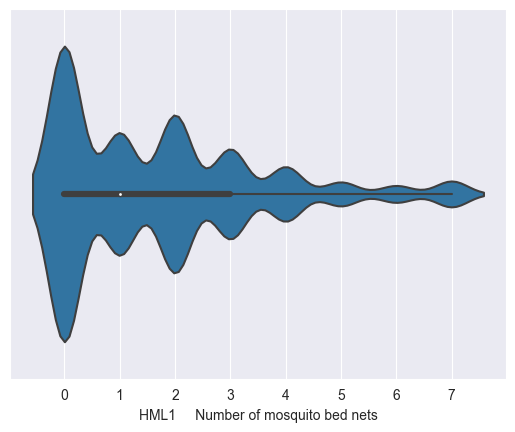

Feature Name:  HV004    Ultimate area unit
Number of Unique Values:  567
Data set description
DescribeResult(nobs=10655, minmax=(1.0, 568.0), mean=251.6700140778977, variance=22562.32811803059, skewness=0.29961547980207176, kurtosis=-0.8771218758912225)
Central Tendency and Dispersion:  {'Mean': 251.6700140778977, 'Median': 237.0, 'Mode': 63.0, 'Variance': 22560.210583716365, 'Standard Deviation': 150.20056785417412, 'Kurtosis': -0.8771218758912225, 'Screw': 0.29961547980207176}
Plotting the count plot


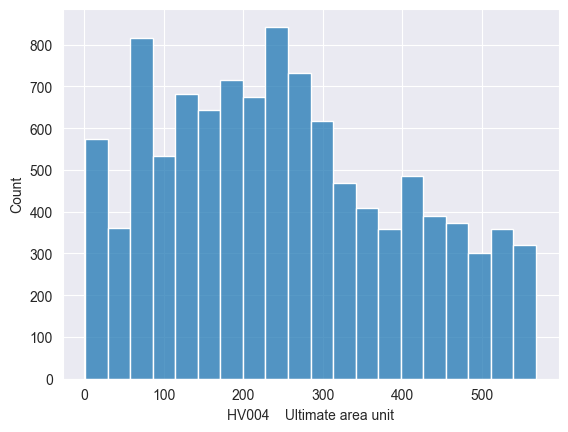

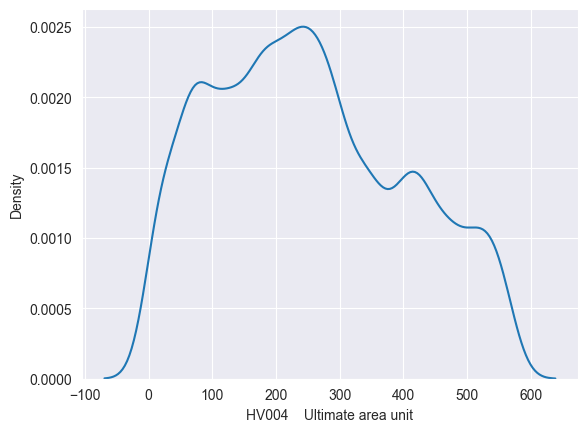

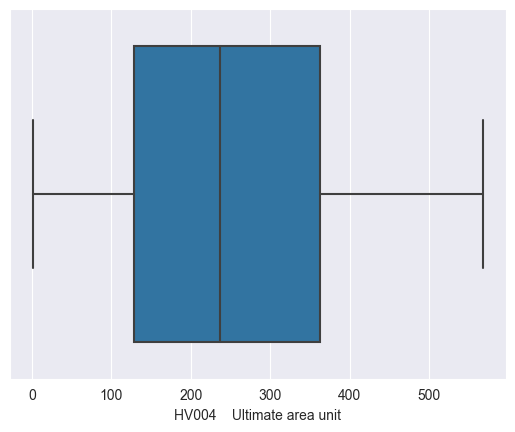

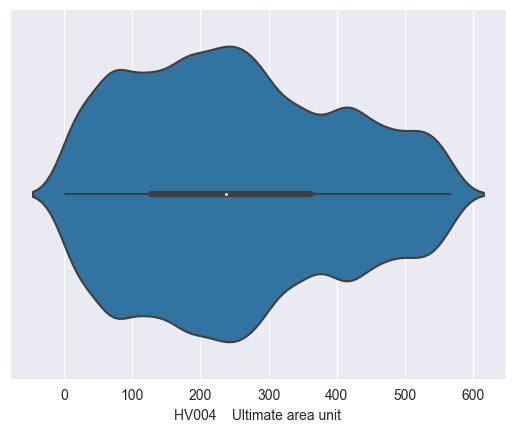

Feature Name:  HV009    Number of household members
Number of Unique Values:  32
Data set description
DescribeResult(nobs=10655, minmax=(2.0, 46.0), mean=7.610980760206476, variance=18.483247160789926, skewness=2.430257210171418, kurtosis=11.435069579964972)
Central Tendency and Dispersion:  {'Mean': 7.610980760206476, 'Median': 6.0, 'Mode': 5.0, 'Variance': 18.48151245903856, 'Standard Deviation': 4.299012963348512, 'Kurtosis': 11.435069579964972, 'Screw': 2.430257210171418}
Plotting the count plot


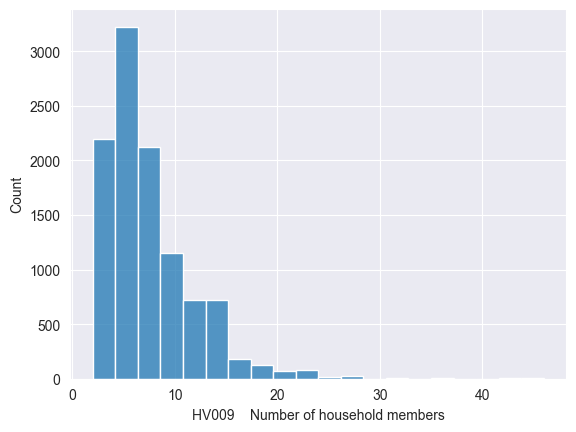

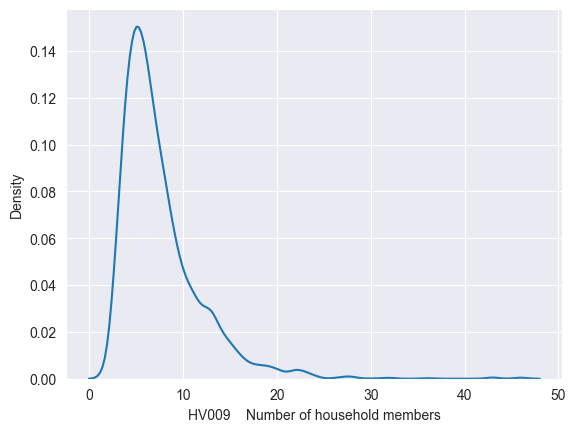

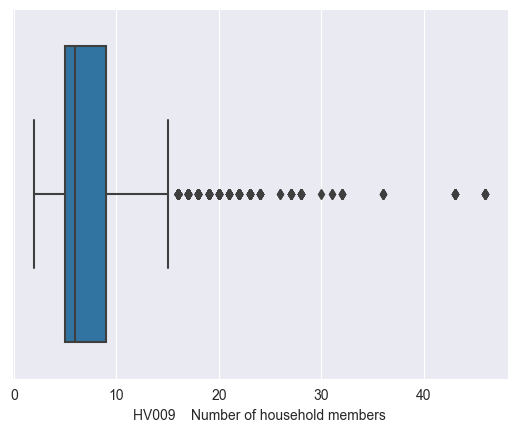

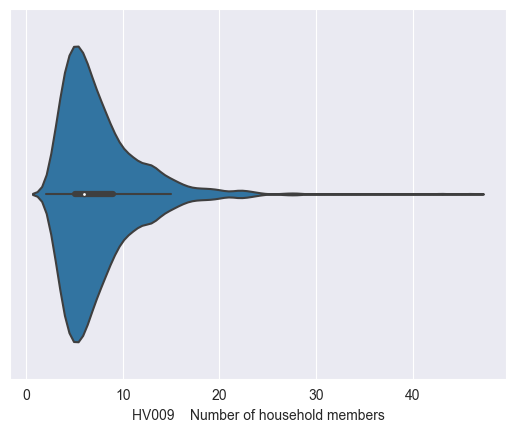

Feature Name:  HV010    Number of eligible women in household
Number of Unique Values:  10
Data set description
DescribeResult(nobs=10655, minmax=(0.0, 9.0), mean=1.4951665884561238, variance=0.979303649268396, skewness=2.167993444042734, kurtosis=7.336330913121984)
Central Tendency and Dispersion:  {'Mean': 1.4951665884561238, 'Median': 1.0, 'Mode': 1.0, 'Variance': 0.9792117390244477, 'Standard Deviation': 0.9895512816546941, 'Kurtosis': 7.336330913121984, 'Screw': 2.167993444042734}
Plotting the count plot


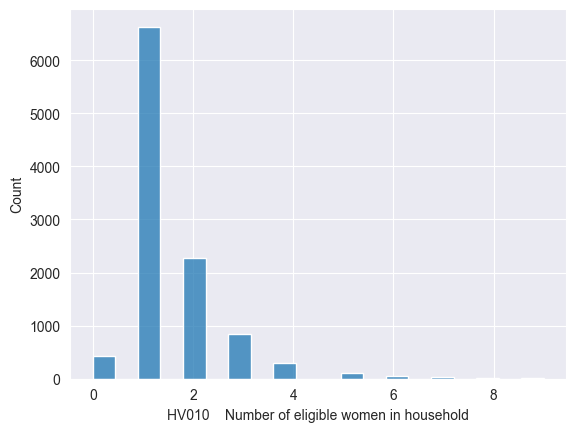

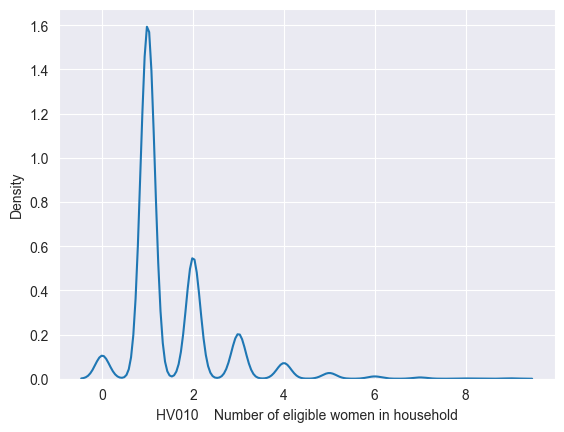

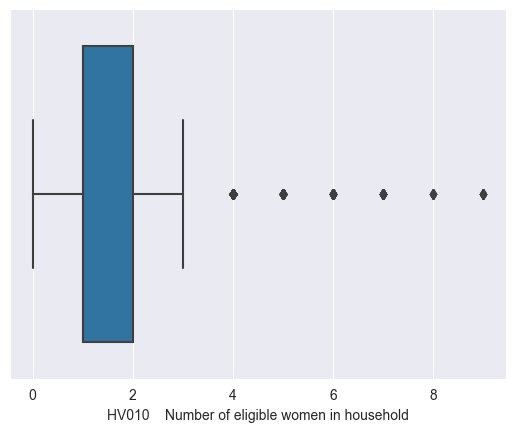

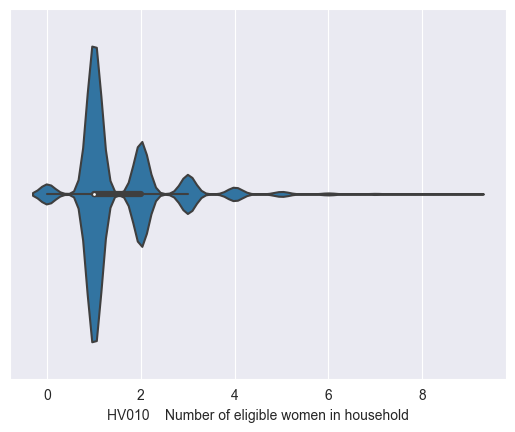

Feature Name:  HV012    Number of de jure members
Number of Unique Values:  33
Data set description
DescribeResult(nobs=10655, minmax=(1.0, 45.0), mean=7.552979821679963, variance=18.287576768412027, skewness=2.406524564187122, kurtosis=11.181668712665559)
Central Tendency and Dispersion:  {'Mean': 7.552979821679963, 'Median': 6.0, 'Mode': 5.0, 'Variance': 18.285860430845773, 'Standard Deviation': 4.276196958846233, 'Kurtosis': 11.181668712665559, 'Screw': 2.406524564187122}
Plotting the count plot


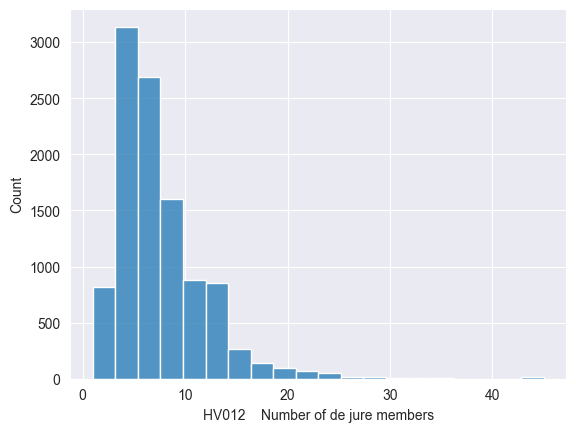

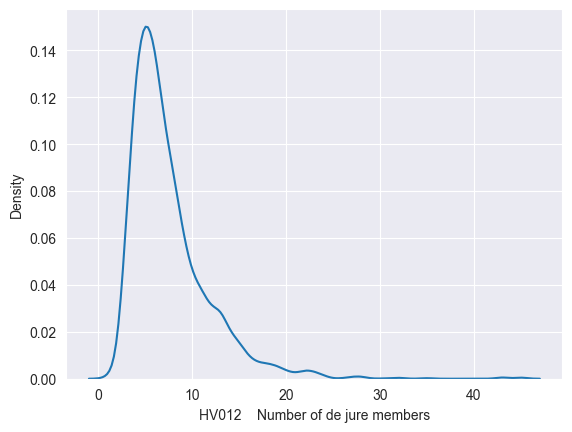

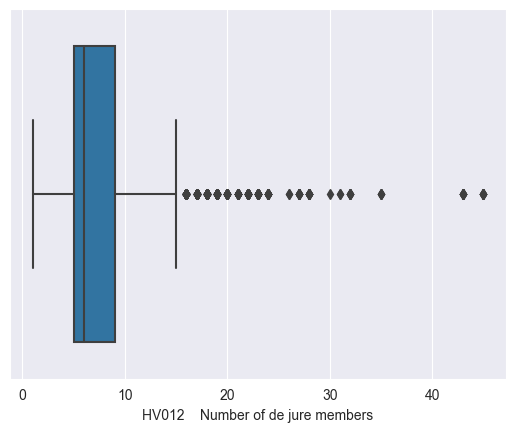

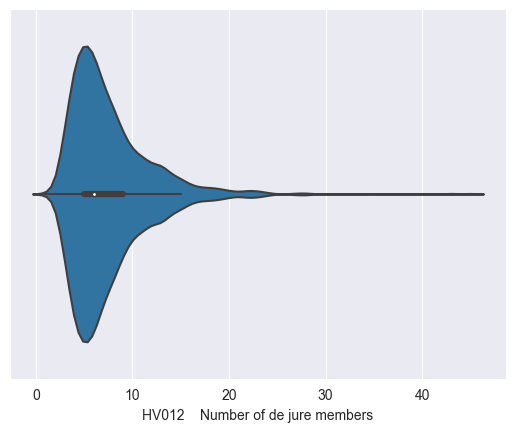

Feature Name:  HV013    Number of de facto members
Number of Unique Values:  36
Data set description
DescribeResult(nobs=10655, minmax=(0.0, 46.0), mean=7.520882214922572, variance=17.938905923332058, skewness=2.2844913927813186, kurtosis=9.997121441434713)
Central Tendency and Dispersion:  {'Mean': 7.520882214922572, 'Median': 6.0, 'Mode': 5.0, 'Variance': 17.93722230944906, 'Standard Deviation': 4.235235803287588, 'Kurtosis': 9.997121441434713, 'Screw': 2.2844913927813186}
Plotting the count plot


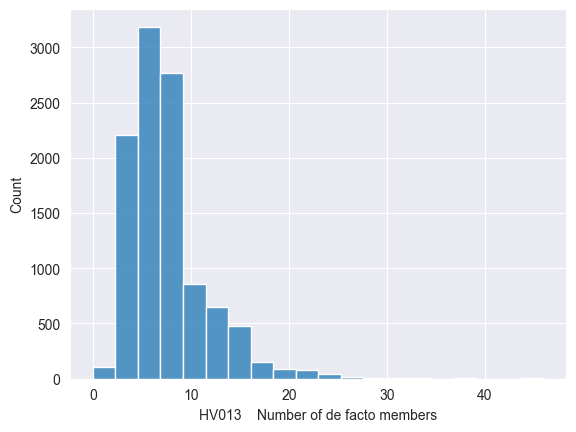

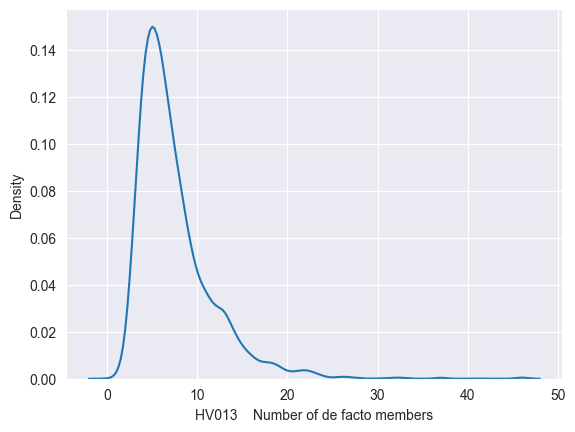

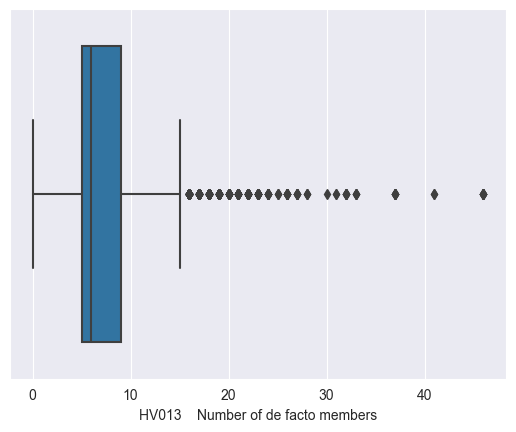

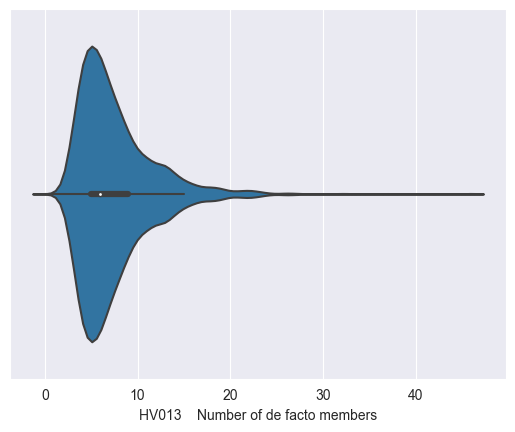

Feature Name:  HV014    Number of children 5 and under (de jure)
Number of Unique Values:  12
Data set description
DescribeResult(nobs=10655, minmax=(0.0, 14.0), mean=2.422524636320976, variance=1.9260178418699987, skewness=2.0451400409111096, kurtosis=8.677339985325219)
Central Tendency and Dispersion:  {'Mean': 2.422524636320976, 'Median': 2.0, 'Mode': 2.0, 'Variance': 1.9258370799890159, 'Standard Deviation': 1.3877453224525802, 'Kurtosis': 8.677339985325219, 'Screw': 2.0451400409111096}
Plotting the count plot


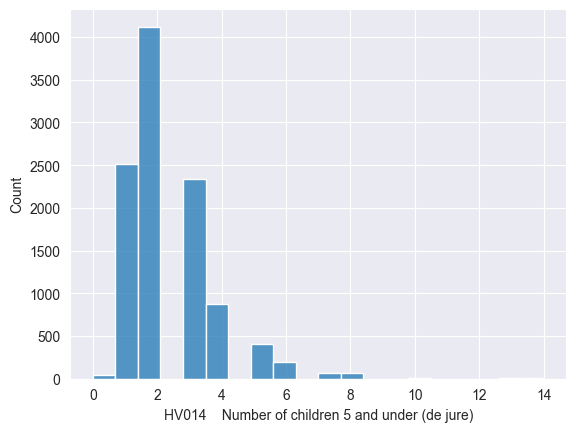

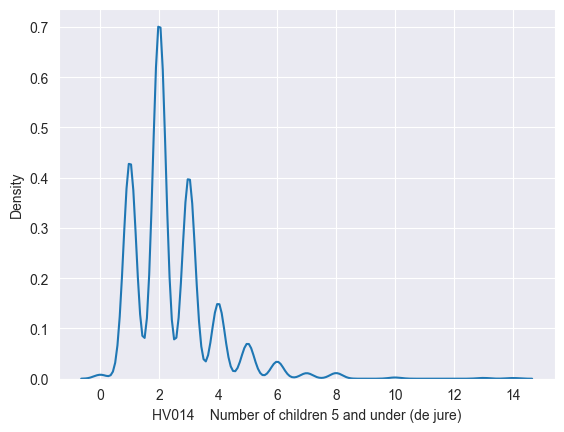

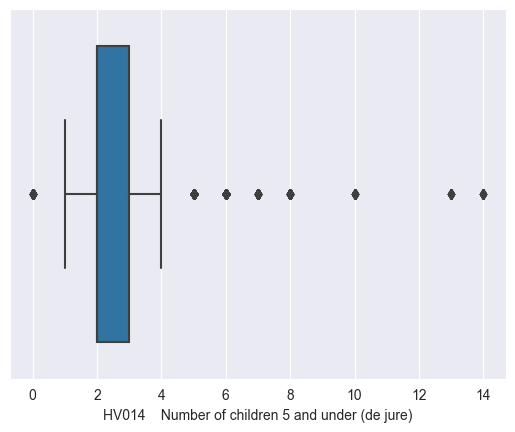

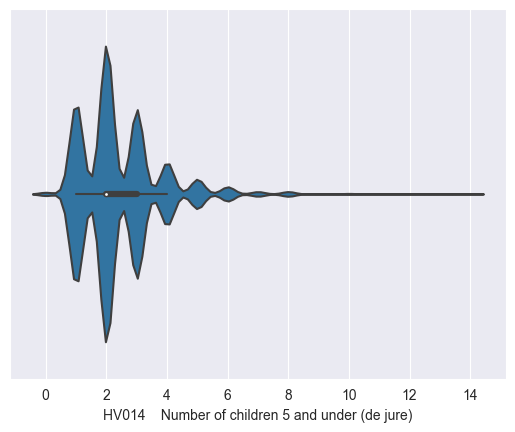

Feature Name:  HV204    Time to get to water source (minutes)
Number of Unique Values:  59
Error in feature:  HV204    Time to get to water source (minutes)
Feature Name:  HV205    Type of toilet facility
Number of Unique Values:  13
Error in feature:  HV205    Type of toilet facility
Feature Name:  HV206    Has electricity
Number of Unique Values:  2
Unique Values:  ['Yes' 'No']
Value Counts:  HV206    Has electricity
No     6404
Yes    4251
Name: count, dtype: int64


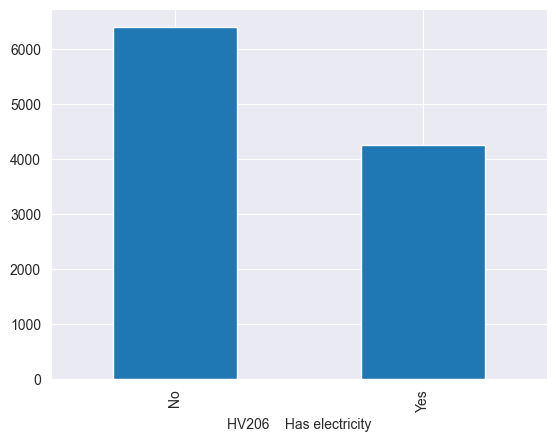

Error in feature:  HV206    Has electricity
Feature Name:  HV207    Has radio
Number of Unique Values:  2
Unique Values:  ['No' 'Yes']
Value Counts:  HV207    Has radio
No     6301
Yes    4354
Name: count, dtype: int64


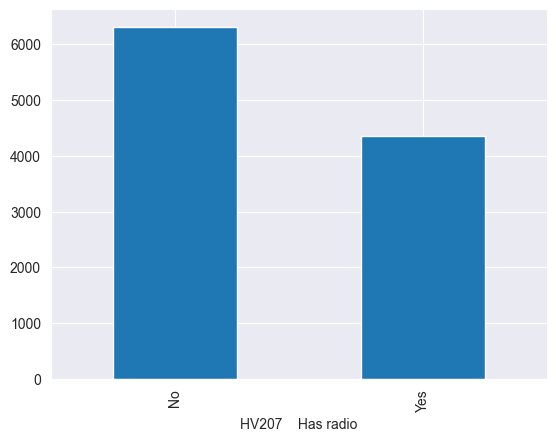

Error in feature:  HV207    Has radio
Feature Name:  HV208    Has television
Number of Unique Values:  2
Unique Values:  ['No' 'Yes']
Value Counts:  HV208    Has television
No     6763
Yes    3892
Name: count, dtype: int64


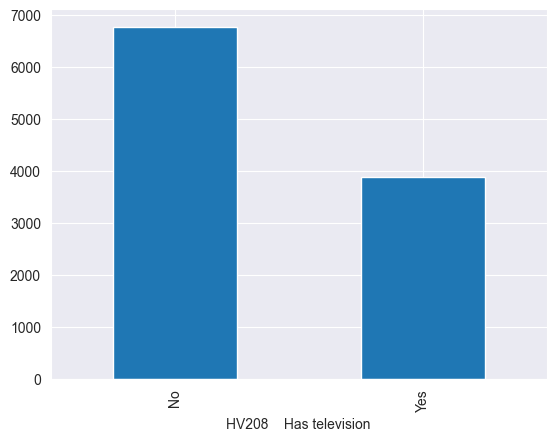

Error in feature:  HV208    Has television
Feature Name:  HV209    Has refrigerator
Number of Unique Values:  2
Unique Values:  ['No' 'Yes']
Value Counts:  HV209    Has refrigerator
No     8561
Yes    2094
Name: count, dtype: int64


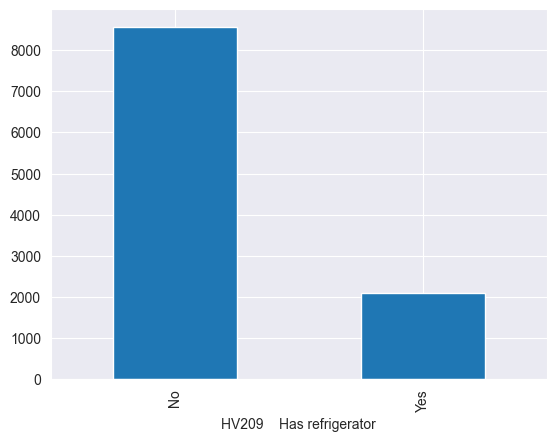

Error in feature:  HV209    Has refrigerator
Feature Name:  HV210    Has bicycle
Number of Unique Values:  2
Unique Values:  ['No' 'Yes']
Value Counts:  HV210    Has bicycle
No     9111
Yes    1544
Name: count, dtype: int64


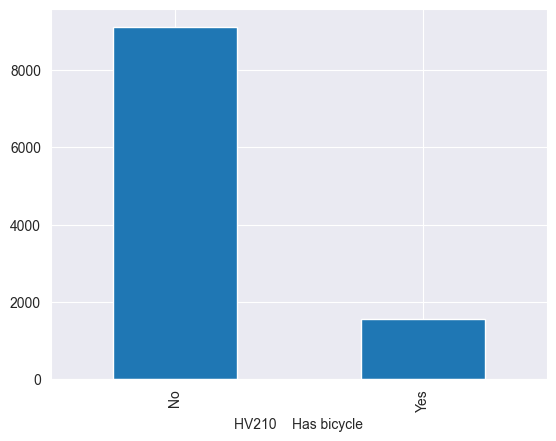

Error in feature:  HV210    Has bicycle
Feature Name:  HV211    Has motorcyclescooter
Number of Unique Values:  2
Unique Values:  ['No' 'Yes']
Value Counts:  HV211    Has motorcyclescooter
No     6920
Yes    3735
Name: count, dtype: int64


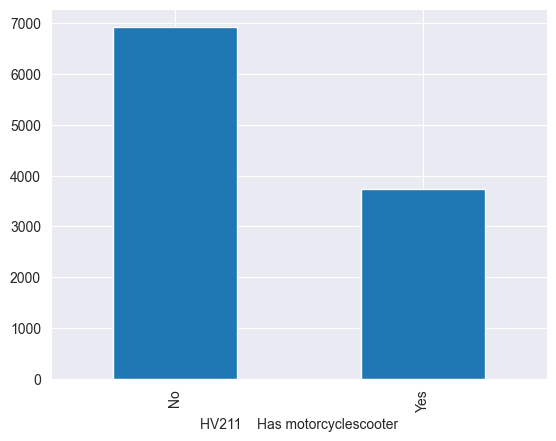

Error in feature:  HV211    Has motorcyclescooter
Feature Name:  HV212    Has cartruck
Number of Unique Values:  2
Unique Values:  ['No' 'Yes']
Value Counts:  HV212    Has cartruck
No     9663
Yes     992
Name: count, dtype: int64


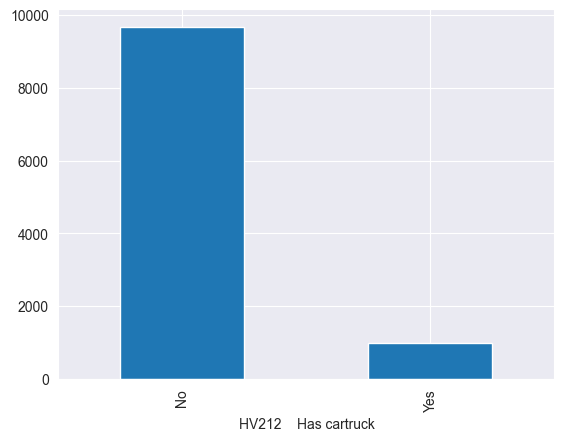

Error in feature:  HV212    Has cartruck
Feature Name:  HV213    Main floor material
Number of Unique Values:  10
Error in feature:  HV213    Main floor material
Feature Name:  HV214    Main wall material
Number of Unique Values:  16
Error in feature:  HV214    Main wall material
Feature Name:  HV215    Main roof material
Number of Unique Values:  15
Error in feature:  HV215    Main roof material
Feature Name:  HV216    Number of rooms used for sleeping
Number of Unique Values:  20
Data set description
DescribeResult(nobs=10655, minmax=(1.0, 24.0), mean=2.797653683716565, variance=3.404894062520454, skewness=2.7833785616475715, kurtosis=16.231537016726037)
Central Tendency and Dispersion:  {'Mean': 2.797653683716565, 'Median': 2.0, 'Mode': 2.0, 'Variance': 3.404574504185163, 'Standard Deviation': 1.8451489111139954, 'Kurtosis': 16.231537016726037, 'Screw': 2.7833785616475715}
Plotting the count plot


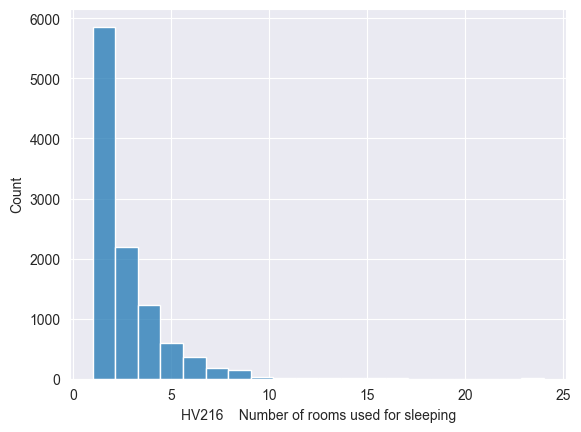

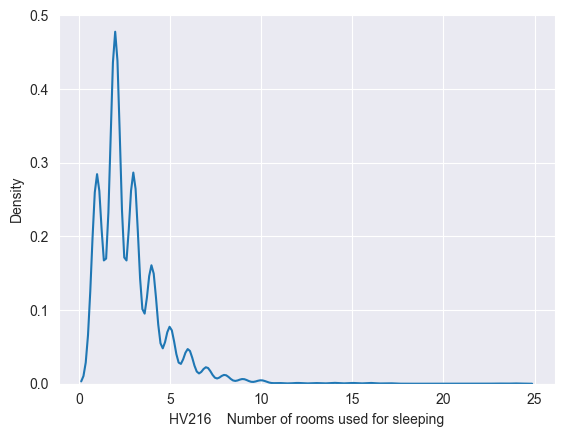

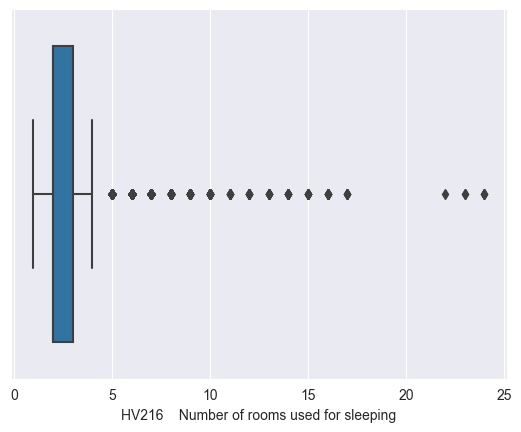

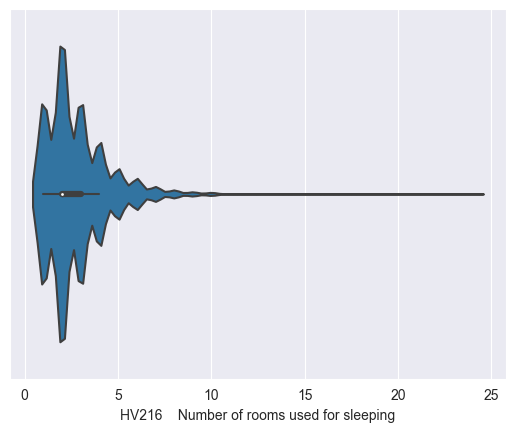

Feature Name:  HV219    Sex of head of household
Number of Unique Values:  2
Unique Values:  ['Male' 'Female']
Value Counts:  HV219    Sex of head of household
Male      9672
Female     983
Name: count, dtype: int64


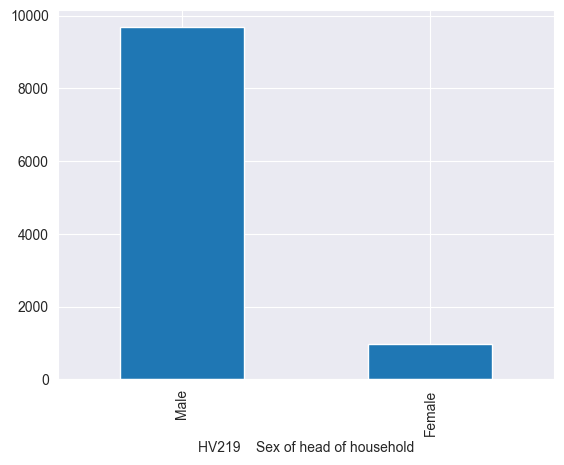

Error in feature:  HV219    Sex of head of household
Feature Name:  HV220    Age of head of household
Number of Unique Values:  70
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


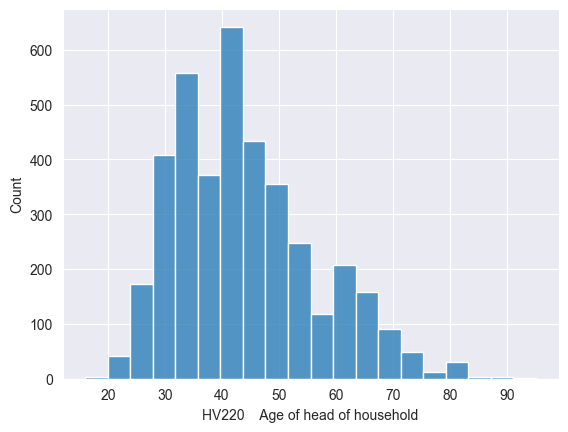

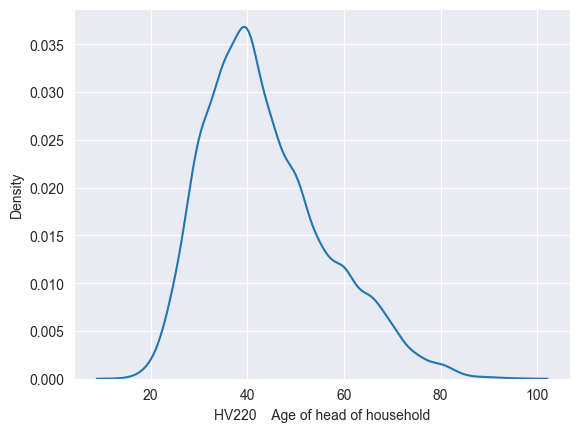

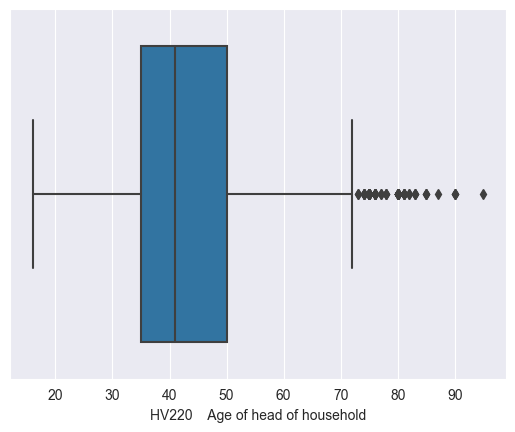

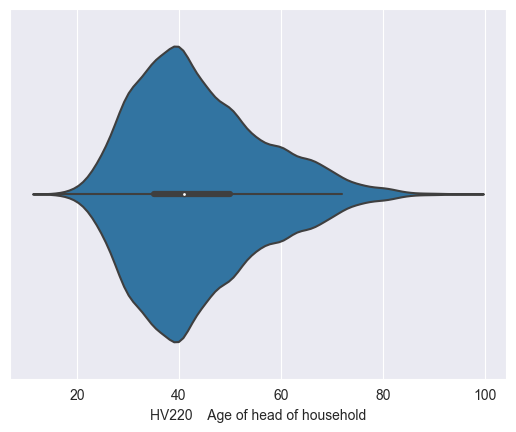

Feature Name:  HV221    Has telephone (land-line)
Number of Unique Values:  2
Unique Values:  ['No' 'Yes']
Value Counts:  HV221    Has telephone (land-line)
No     10540
Yes      115
Name: count, dtype: int64


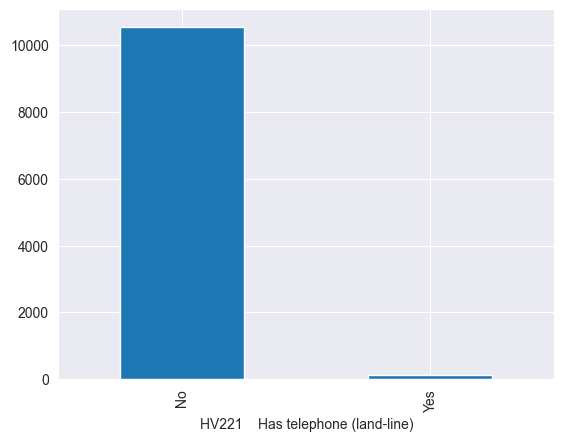

Error in feature:  HV221    Has telephone (land-line)
Feature Name:  HV222    Type of cookstove
Number of Unique Values:  11
Error in feature:  HV222    Type of cookstove
Feature Name:  HV225    Share toilet with other households
Number of Unique Values:  2
Unique Values:  ['No' 'Yes' nan]
Value Counts:  HV225    Share toilet with other households
No     5620
Yes    2380
Name: count, dtype: int64


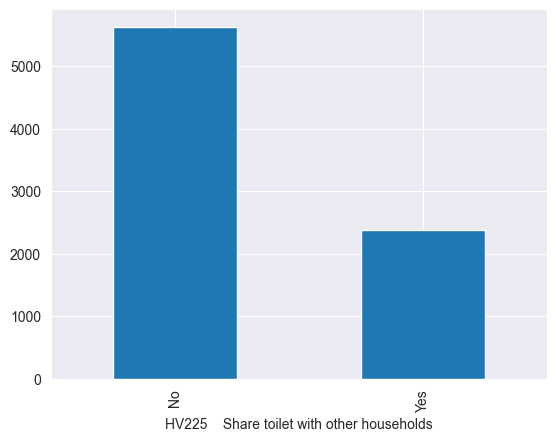

Error in feature:  HV225    Share toilet with other households
Feature Name:  HV227    Has mosquito bed net for sleeping
Number of Unique Values:  2
Unique Values:  ['No' 'Yes']
Value Counts:  HV227    Has mosquito bed net for sleeping
Yes    6648
No     4007
Name: count, dtype: int64


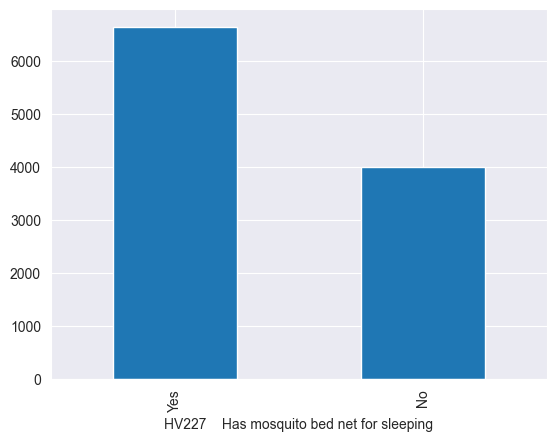

Error in feature:  HV227    Has mosquito bed net for sleeping
Feature Name:  HV228    Children under 5 slept under mosquito bed net last night
Number of Unique Values:  4
Unique Values:  ['No net in household' 'No' 'All children' 'Some children' nan]
Value Counts:  HV228    Children under 5 slept under mosquito bed net last night
No net in household    4000
All children           3484
No                     1669
Some children          1477
Name: count, dtype: int64


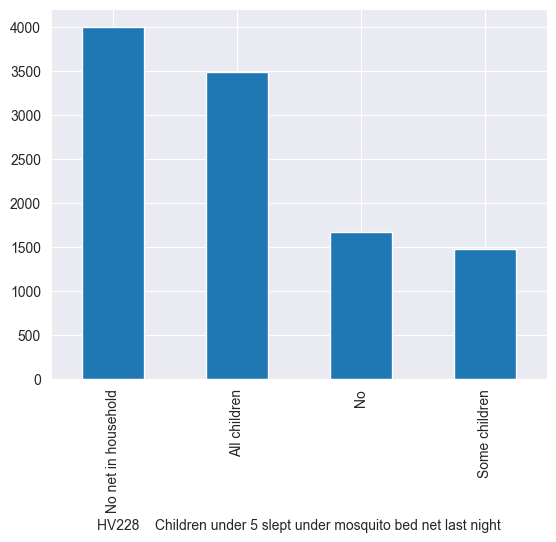

Error in feature:  HV228    Children under 5 slept under mosquito bed net last night
Feature Name:  HV235    Location of source for water
Number of Unique Values:  3
Unique Values:  ['Elsewhere' 'In own yard/plot' 'In own dwelling' nan]
Value Counts:  HV235    Location of source for water
Elsewhere           6424
In own yard/plot    2296
In own dwelling      992
Name: count, dtype: int64


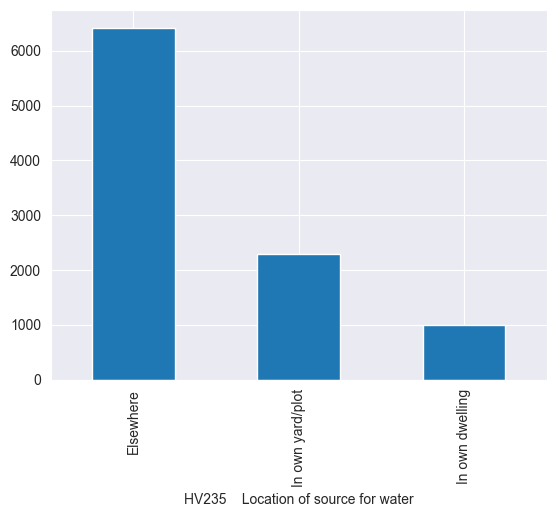

Error in feature:  HV235    Location of source for water
Feature Name:  HV238    Number of households sharing toilet
Number of Unique Values:  6
Unique Values:  [nan  3.  4.  2.  6.  9.  5.]
Value Counts:  HV238    Number of households sharing toilet
2.0    23
4.0    10
3.0     7
9.0     2
6.0     1
5.0     1
Name: count, dtype: int64


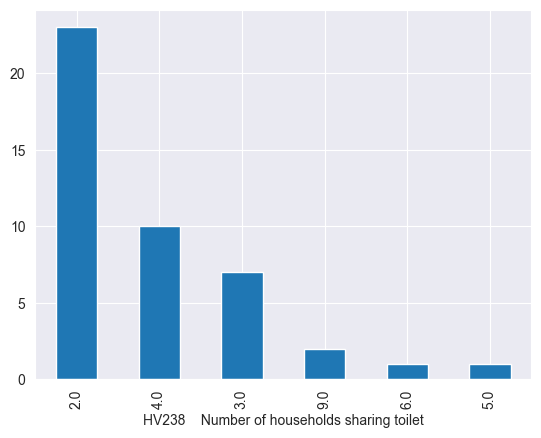

Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


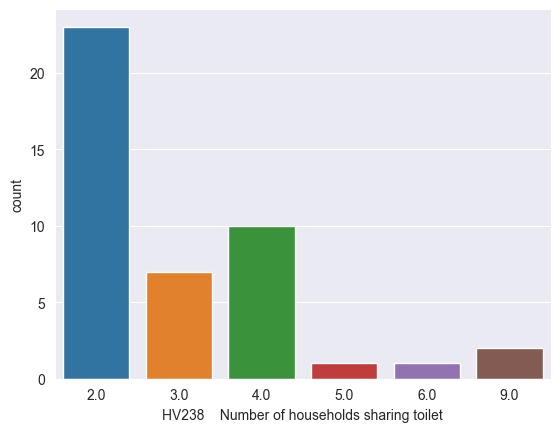

Error in feature:  HV238    Number of households sharing toilet
Feature Name:  HV244    Owns land usable for agriculture
Number of Unique Values:  2
Unique Values:  ['No' 'Yes']
Value Counts:  HV244    Owns land usable for agriculture
Yes    6796
No     3859
Name: count, dtype: int64


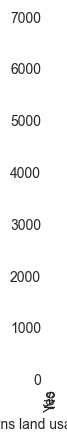

Error in feature:  HV244    Owns land usable for agriculture
Feature Name:  HV245    Hectares of agricultural land (1 decimal)
Number of Unique Values:  55
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


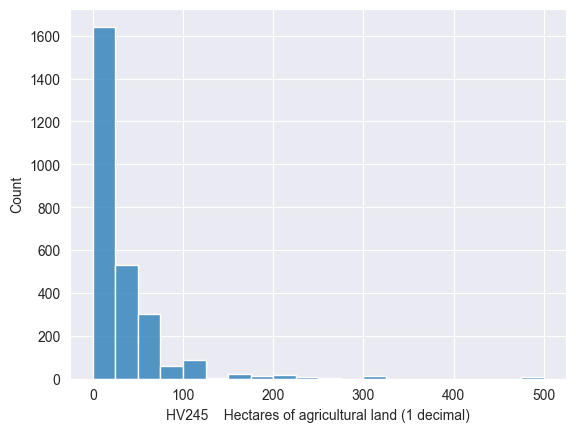

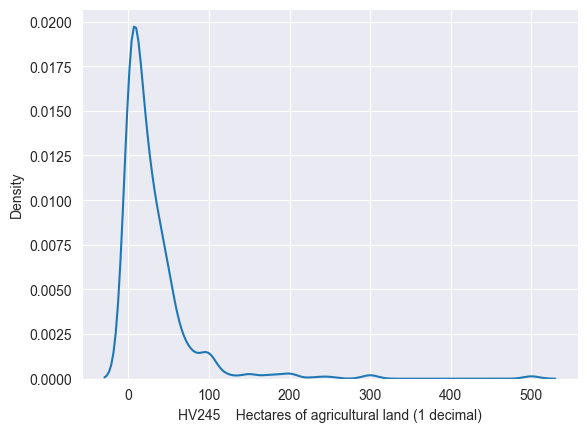

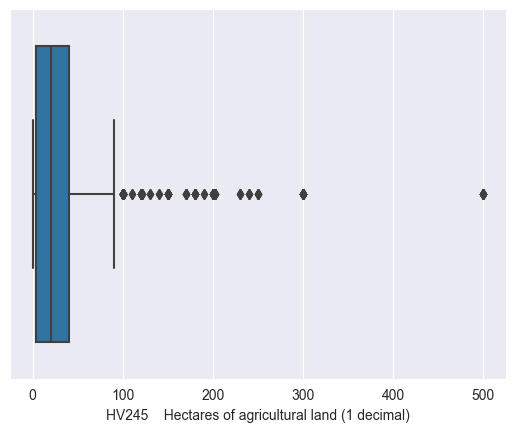

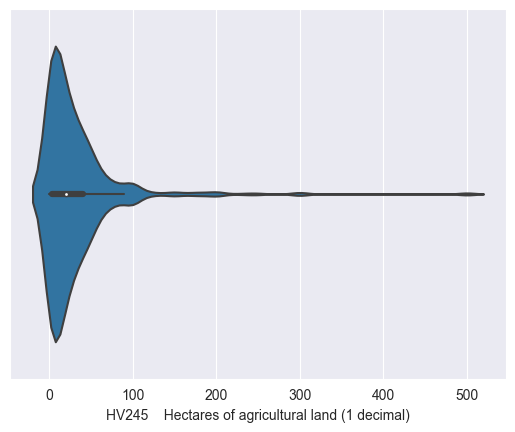

Feature Name:  HV246    Owns livestock, herds or farm animals
Number of Unique Values:  2
Unique Values:  ['Yes' 'No']
Value Counts:  HV246    Owns livestock, herds or farm animals
Yes    5710
No     4945
Name: count, dtype: int64


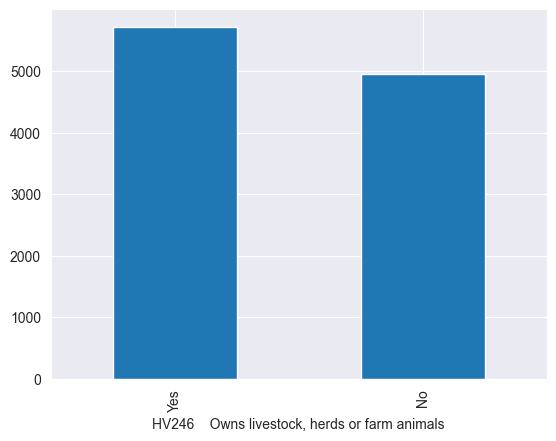

Error in feature:  HV246    Owns livestock, herds or farm animals
Feature Name:  HV246A   Owns cattle
Number of Unique Values:  17
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


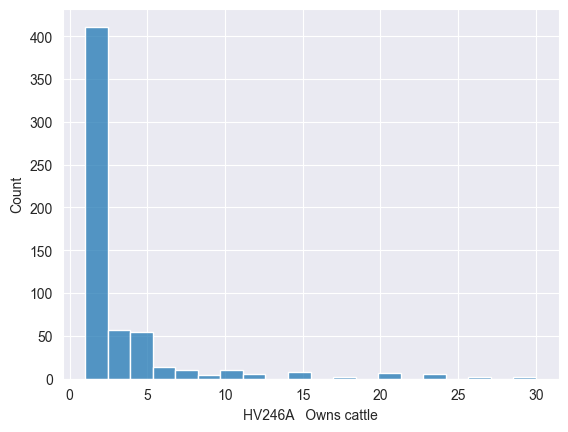

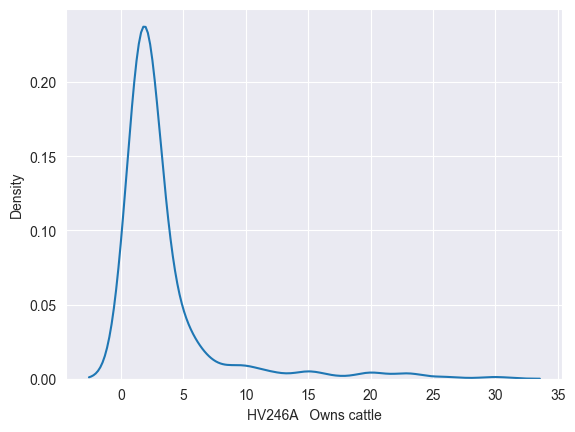

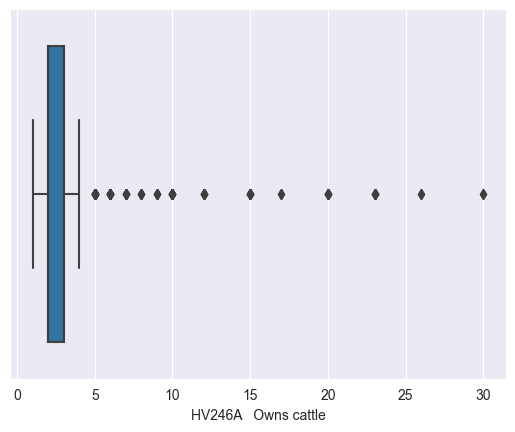

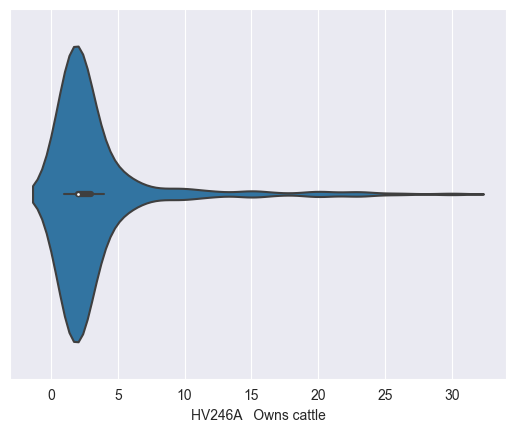

Feature Name:  HV246B   Owns cows bulls
Number of Unique Values:  22
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


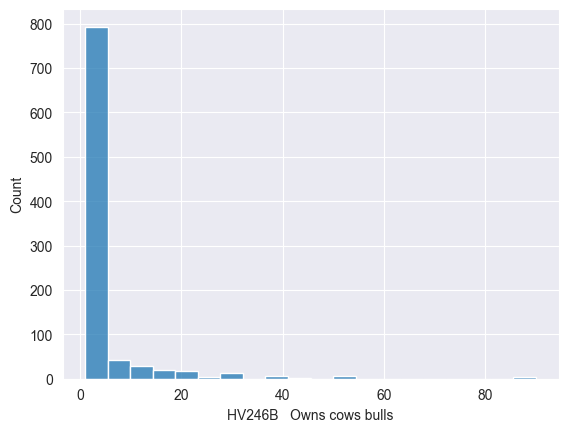

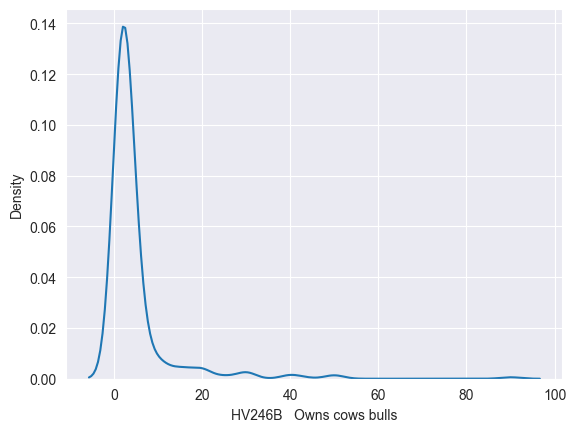

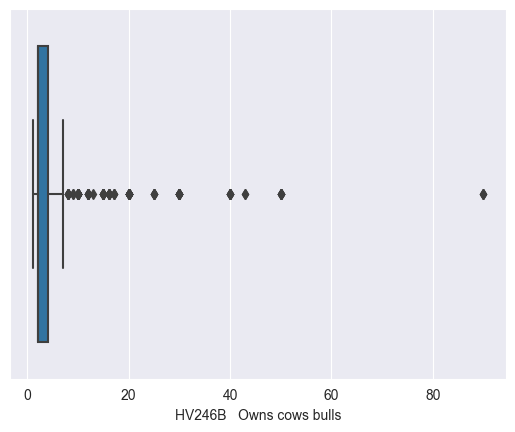

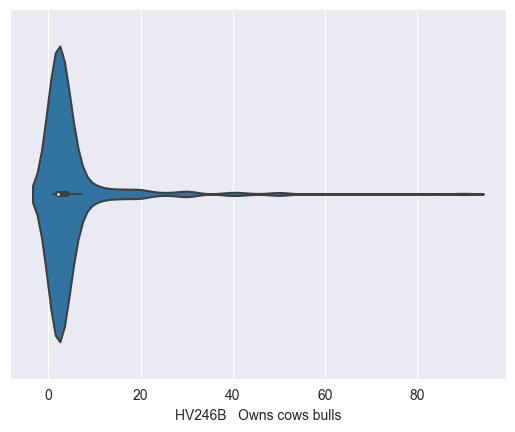

Feature Name:  HV246C   Owns horses donkeys mules
Number of Unique Values:  10
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


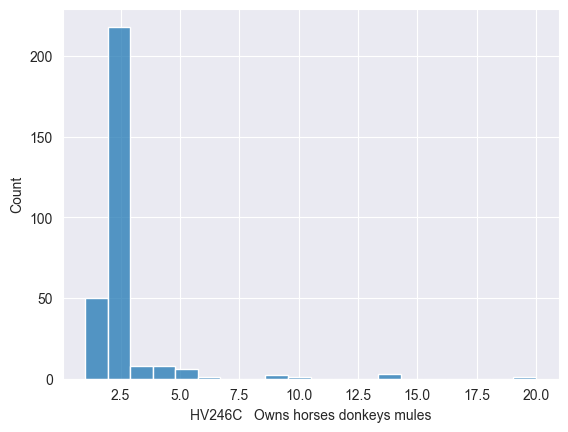

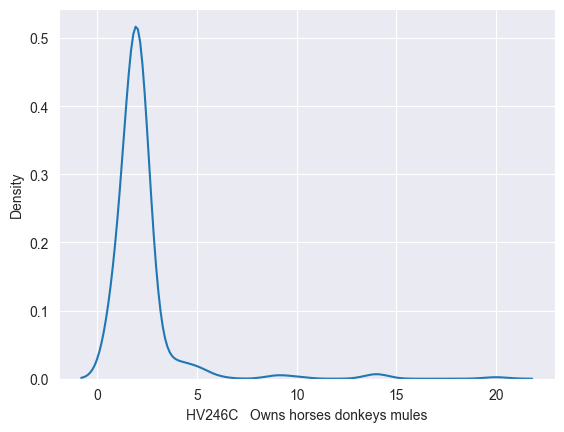

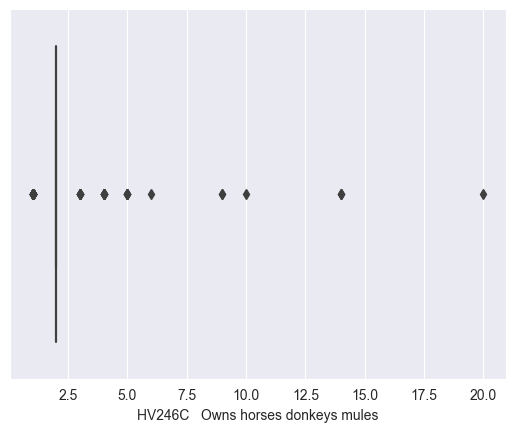

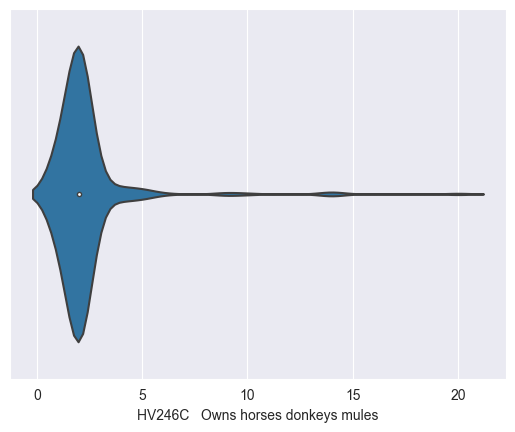

Feature Name:  HV246D   Owns goats
Number of Unique Values:  32
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


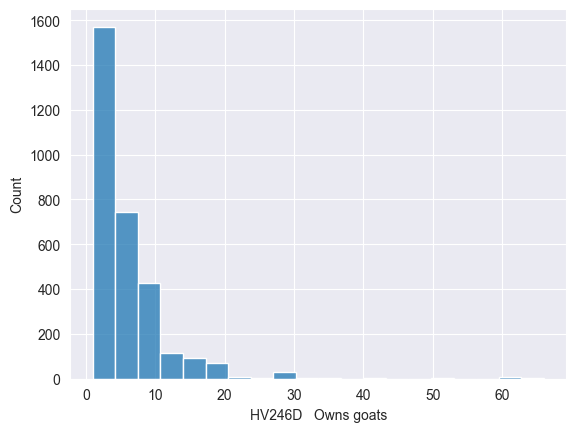

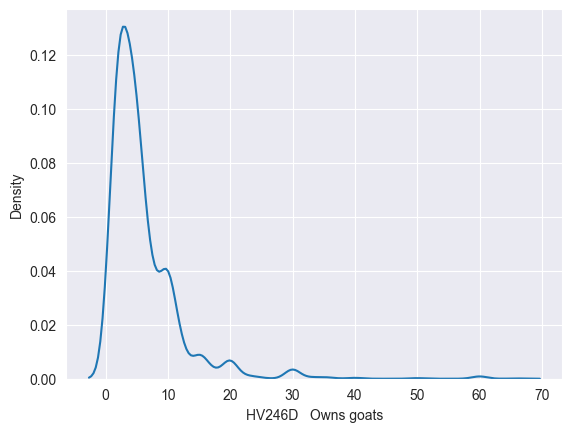

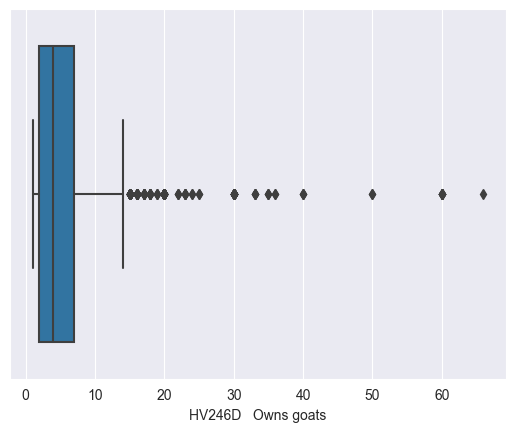

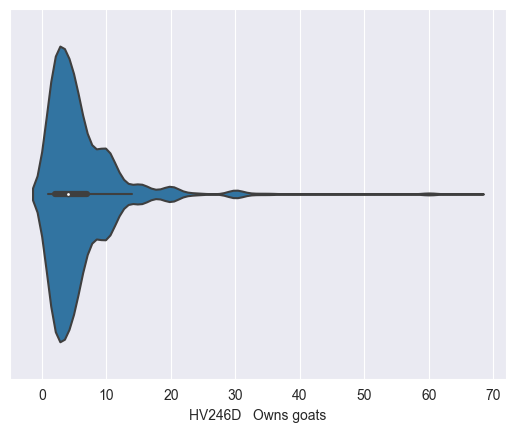

Feature Name:  HV246E   Owns sheep
Number of Unique Values:  28
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


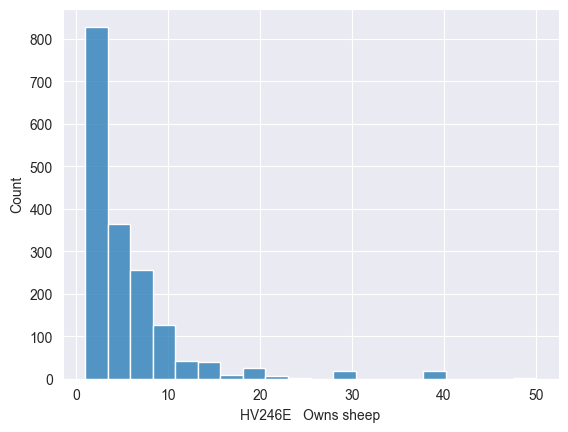

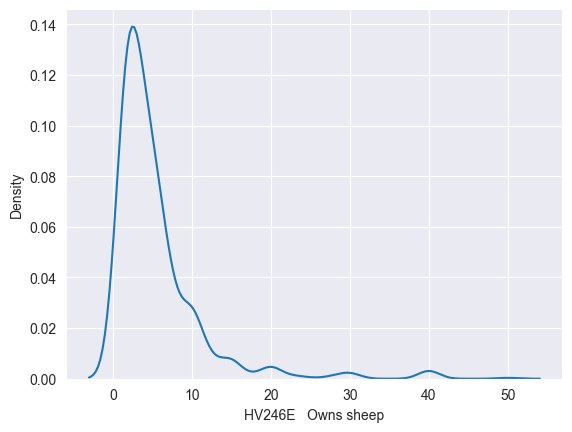

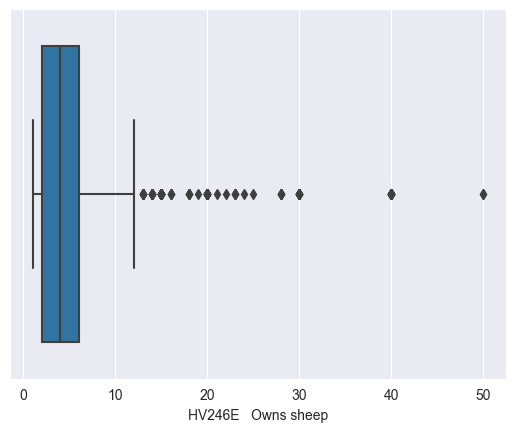

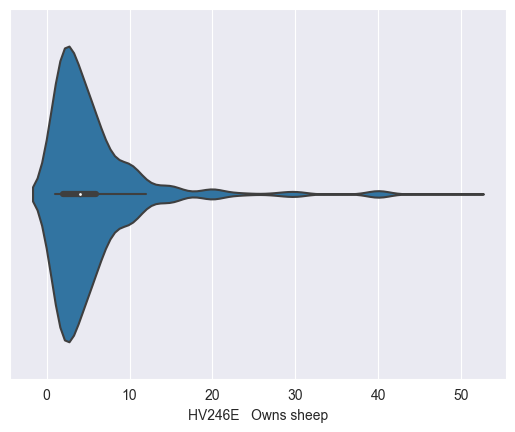

Feature Name:  HV246F   Owns chickenspoultry
Number of Unique Values:  40
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


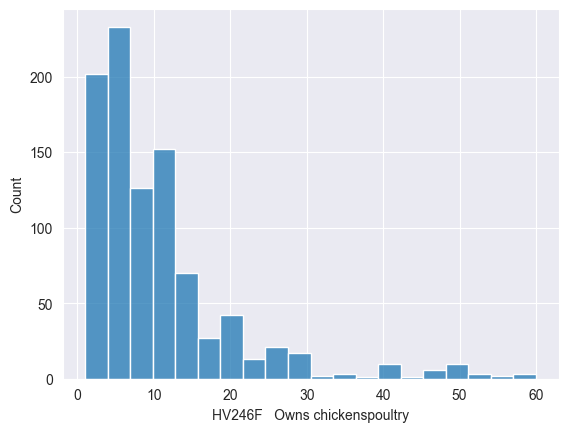

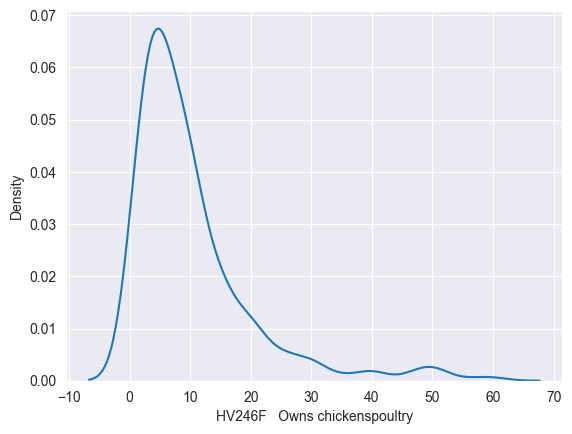

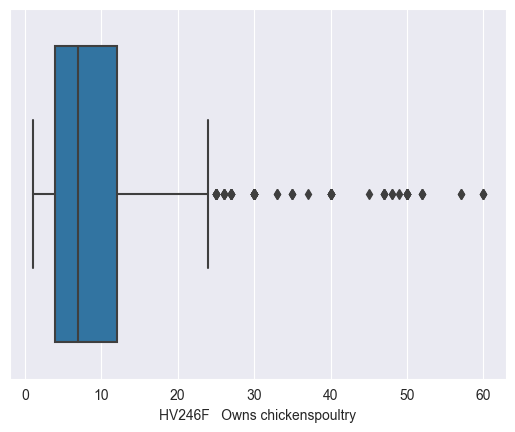

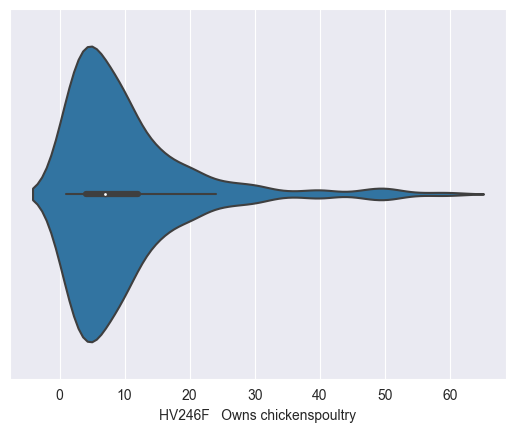

Feature Name:  HV246G   Owns pigs
Number of Unique Values:  16
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


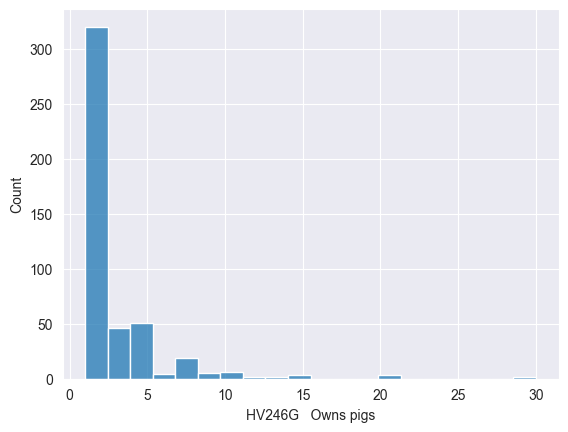

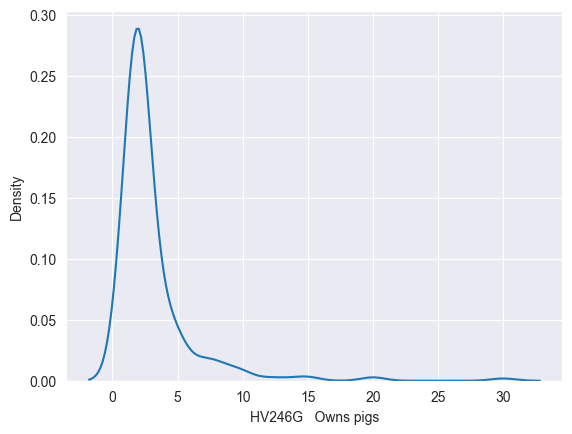

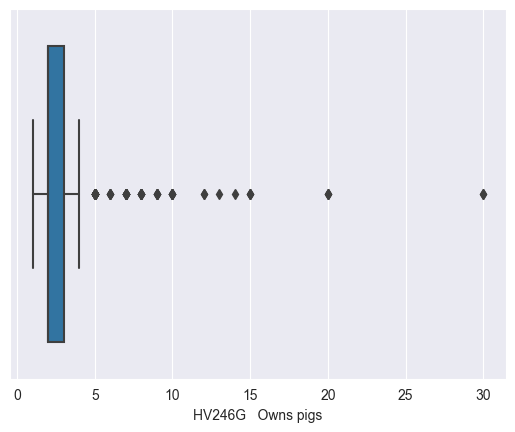

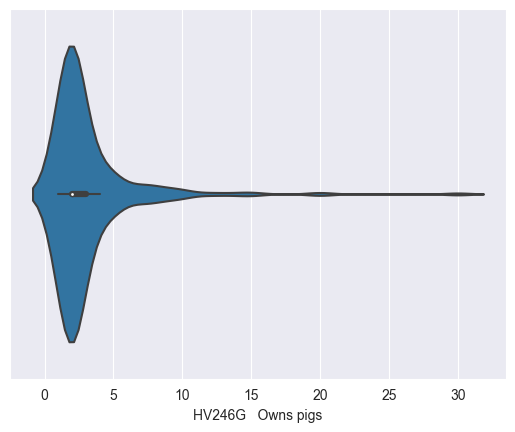

Feature Name:  HV246H   Owns camels
Number of Unique Values:  7
Unique Values:  [nan  2.  1. 10.  3.  6. 32.  5.]
Value Counts:  HV246H   Owns camels
2.0     194
1.0      38
3.0       4
5.0       3
10.0      2
6.0       1
32.0      1
Name: count, dtype: int64


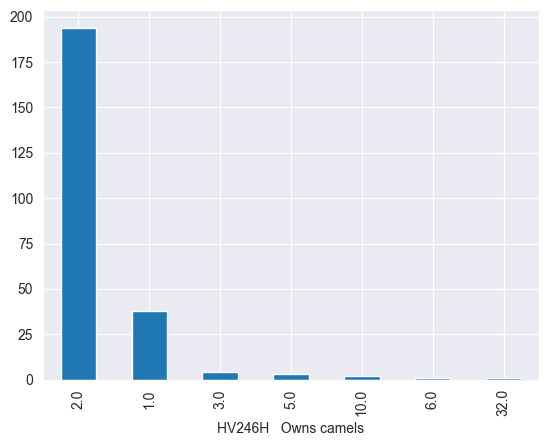

Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


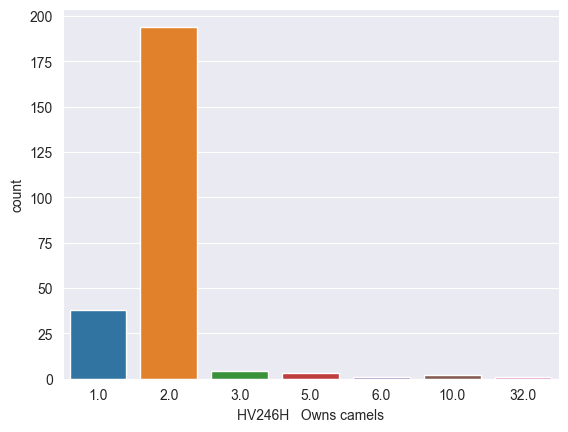

Error in feature:  HV246H   Owns camels
Feature Name:  HV247    Has bank account
Number of Unique Values:  2
Unique Values:  ['Yes' 'No']
Value Counts:  HV247    Has bank account
No     5534
Yes    5121
Name: count, dtype: int64


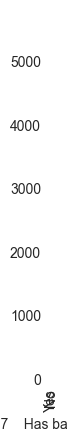

Error in feature:  HV247    Has bank account
Feature Name:  HV270    Wealth index combined
Number of Unique Values:  5
Unique Values:  ['Richer' 'Middle' 'Poorer' 'Richest' 'Poorest']
Value Counts:  HV270    Wealth index combined
Middle     2261
Poorest    2185
Richer     2179
Poorer     2102
Richest    1928
Name: count, dtype: int64


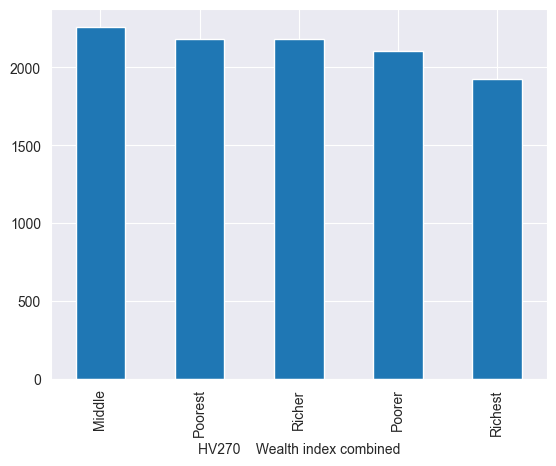

Error in feature:  HV270    Wealth index combined


In [162]:
for col in _socio_economic_data:
    feature_uni_varaite_analysis(col, _socio_economic_data)

# Univariate analysis of the Demographic factors 

In [163]:
_demographic_data = children_under_5[demographic_factors]
# for col in _demographic_data:
    # if _demographic_data[col].dtype == "object":
    #         _demographic_data[col] = LabelEncoder().fit_transform(_demographic_data[col])

Feature Name:  HV009    Number of household members
Number of Unique Values:  32
Data set description
DescribeResult(nobs=10655, minmax=(2.0, 46.0), mean=7.610980760206476, variance=18.483247160789926, skewness=2.430257210171418, kurtosis=11.435069579964972)
Central Tendency and Dispersion:  {'Mean': 7.610980760206476, 'Median': 6.0, 'Mode': 5.0, 'Variance': 18.48151245903856, 'Standard Deviation': 4.299012963348512, 'Kurtosis': 11.435069579964972, 'Screw': 2.430257210171418}
Plotting the count plot


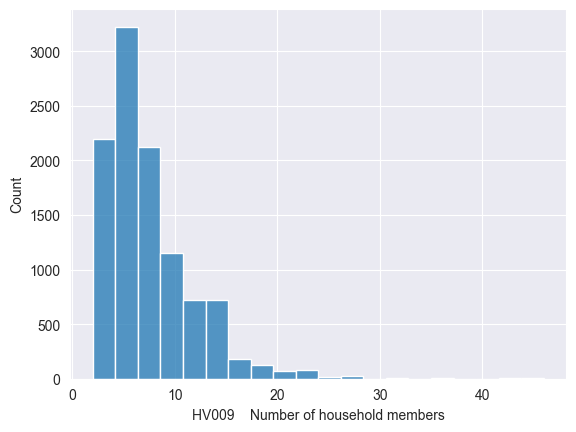

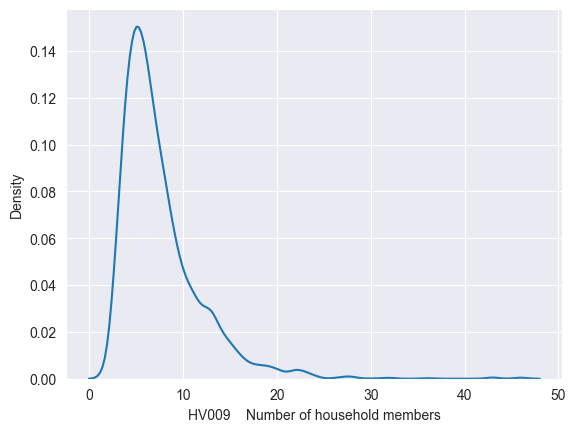

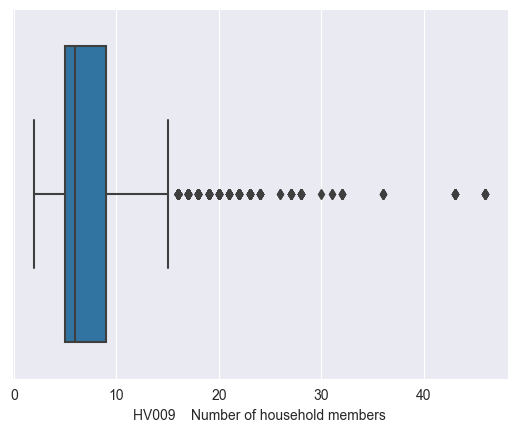

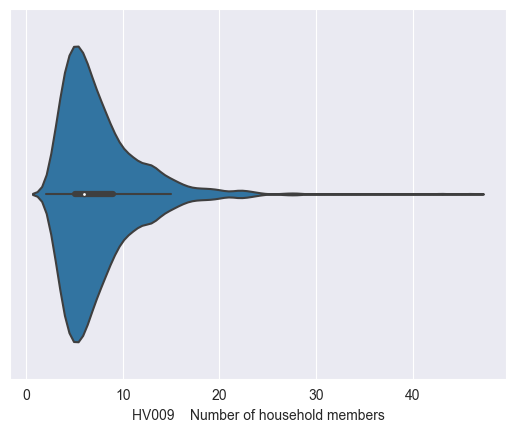

Feature Name:  HV010    Number of eligible women in household
Number of Unique Values:  10
Data set description
DescribeResult(nobs=10655, minmax=(0.0, 9.0), mean=1.4951665884561238, variance=0.979303649268396, skewness=2.167993444042734, kurtosis=7.336330913121984)
Central Tendency and Dispersion:  {'Mean': 1.4951665884561238, 'Median': 1.0, 'Mode': 1.0, 'Variance': 0.9792117390244477, 'Standard Deviation': 0.9895512816546941, 'Kurtosis': 7.336330913121984, 'Screw': 2.167993444042734}
Plotting the count plot


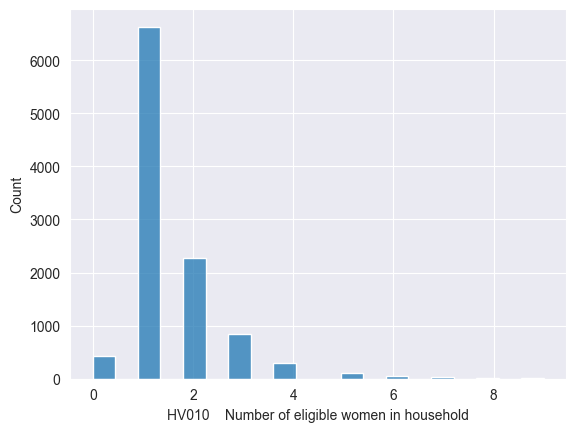

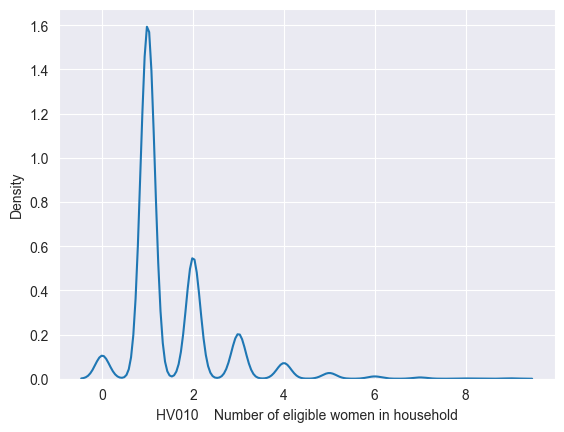

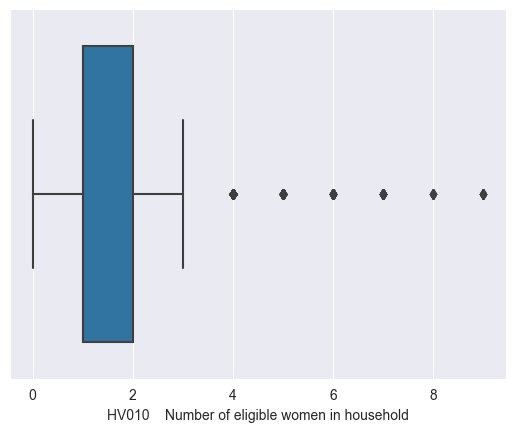

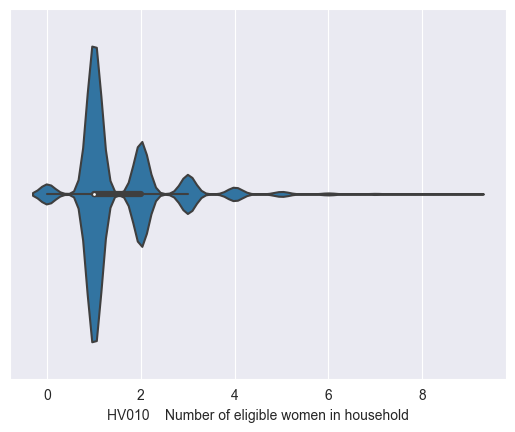

Feature Name:  HV012    Number of de jure members
Number of Unique Values:  33
Data set description
DescribeResult(nobs=10655, minmax=(1.0, 45.0), mean=7.552979821679963, variance=18.287576768412027, skewness=2.406524564187122, kurtosis=11.181668712665559)
Central Tendency and Dispersion:  {'Mean': 7.552979821679963, 'Median': 6.0, 'Mode': 5.0, 'Variance': 18.285860430845773, 'Standard Deviation': 4.276196958846233, 'Kurtosis': 11.181668712665559, 'Screw': 2.406524564187122}
Plotting the count plot


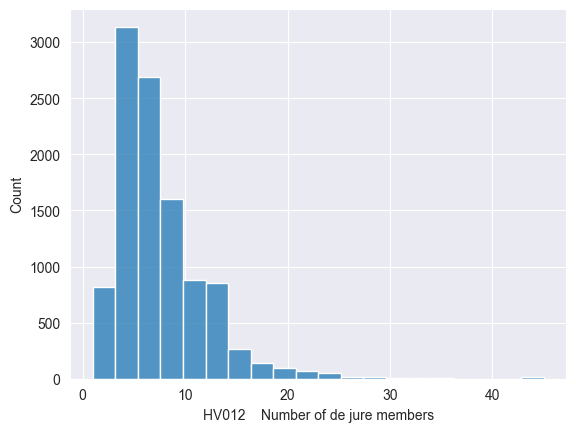

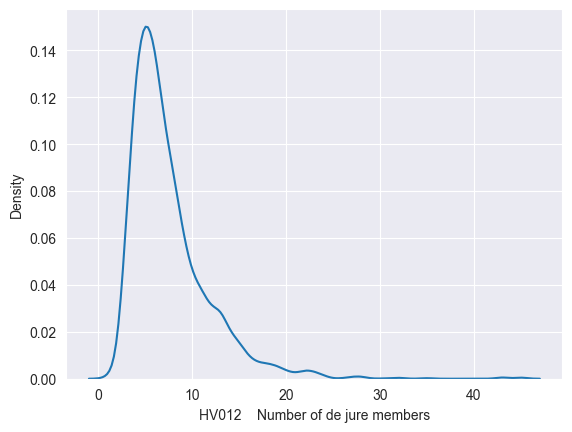

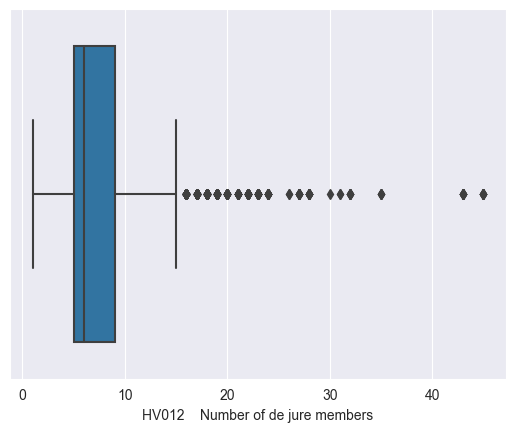

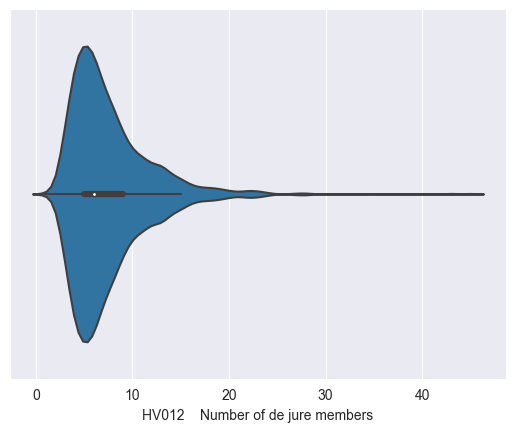

Feature Name:  HV013    Number of de facto members
Number of Unique Values:  36
Data set description
DescribeResult(nobs=10655, minmax=(0.0, 46.0), mean=7.520882214922572, variance=17.938905923332058, skewness=2.2844913927813186, kurtosis=9.997121441434713)
Central Tendency and Dispersion:  {'Mean': 7.520882214922572, 'Median': 6.0, 'Mode': 5.0, 'Variance': 17.93722230944906, 'Standard Deviation': 4.235235803287588, 'Kurtosis': 9.997121441434713, 'Screw': 2.2844913927813186}
Plotting the count plot


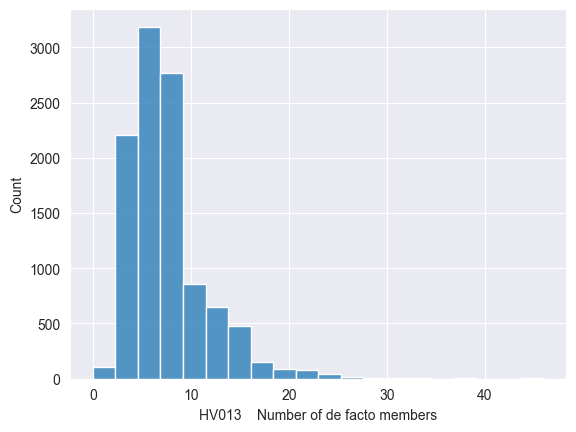

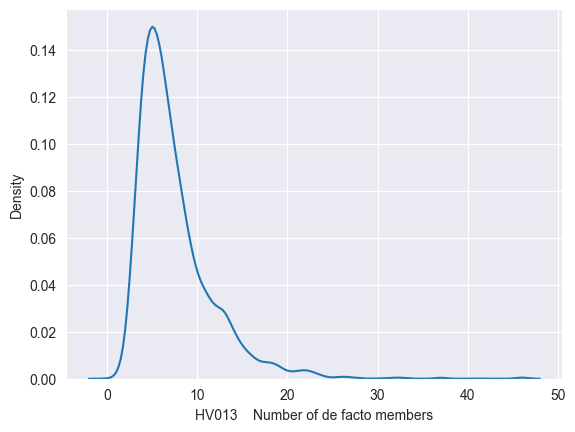

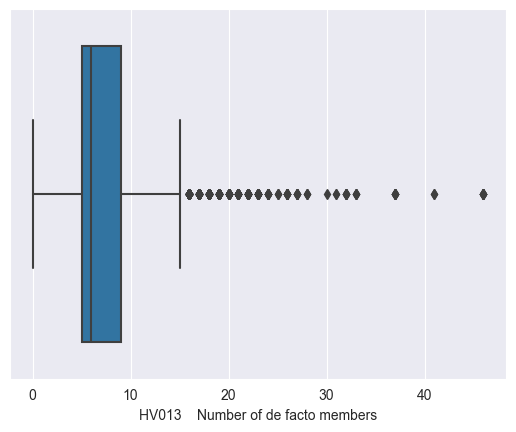

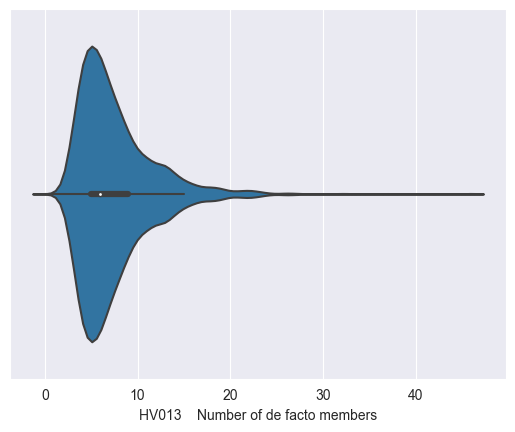

Feature Name:  HV014    Number of children 5 and under (de jure)
Number of Unique Values:  12
Data set description
DescribeResult(nobs=10655, minmax=(0.0, 14.0), mean=2.422524636320976, variance=1.9260178418699987, skewness=2.0451400409111096, kurtosis=8.677339985325219)
Central Tendency and Dispersion:  {'Mean': 2.422524636320976, 'Median': 2.0, 'Mode': 2.0, 'Variance': 1.9258370799890159, 'Standard Deviation': 1.3877453224525802, 'Kurtosis': 8.677339985325219, 'Screw': 2.0451400409111096}
Plotting the count plot


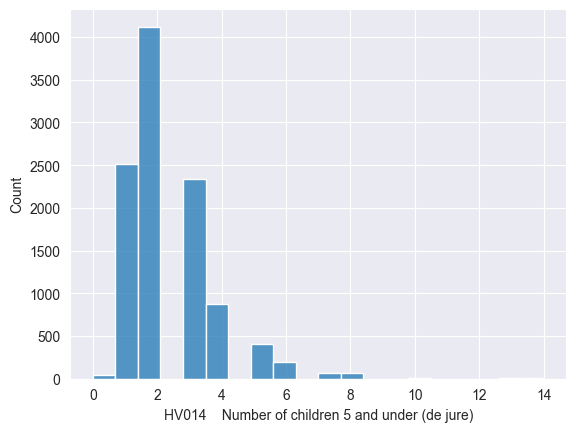

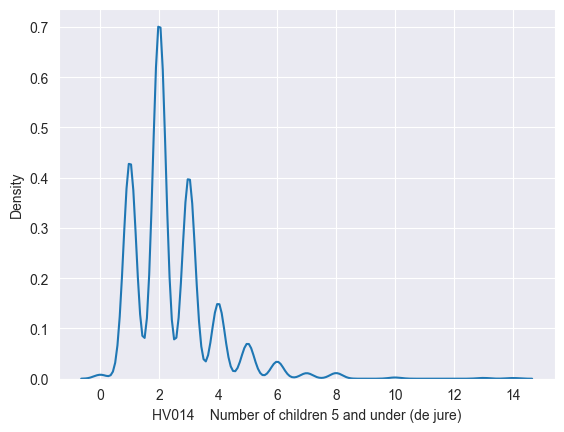

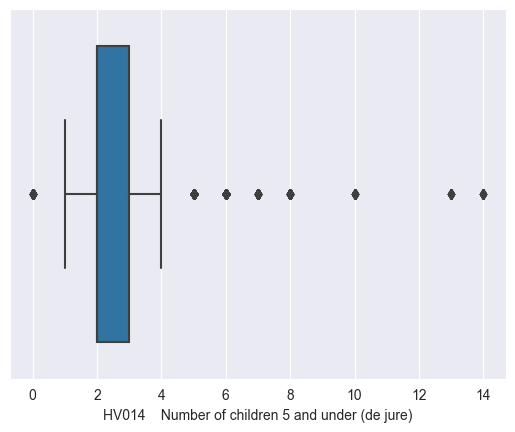

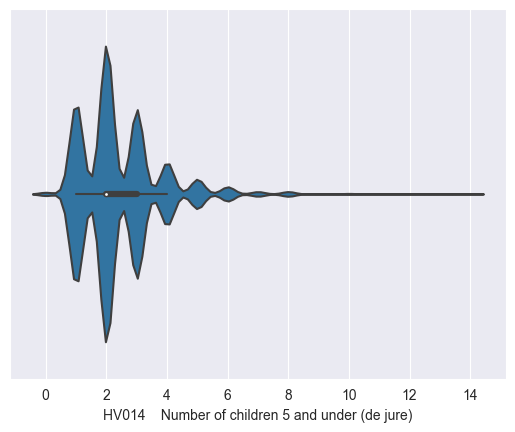

Feature Name:  HV219    Sex of head of household
Number of Unique Values:  2
Unique Values:  ['Male' 'Female']
Value Counts:  HV219    Sex of head of household
Male      9672
Female     983
Name: count, dtype: int64


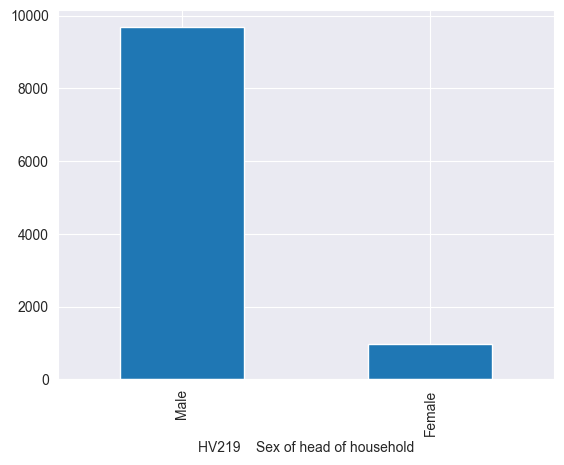

Error in feature:  HV219    Sex of head of household
Feature Name:  HV220    Age of head of household
Number of Unique Values:  70
Data set description
DescribeResult(nobs=10655, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)
Central Tendency and Dispersion:  {'Mean': nan, 'Median': nan, 'Mode': nan, 'Variance': nan, 'Standard Deviation': nan, 'Kurtosis': nan, 'Screw': nan}
Plotting the count plot


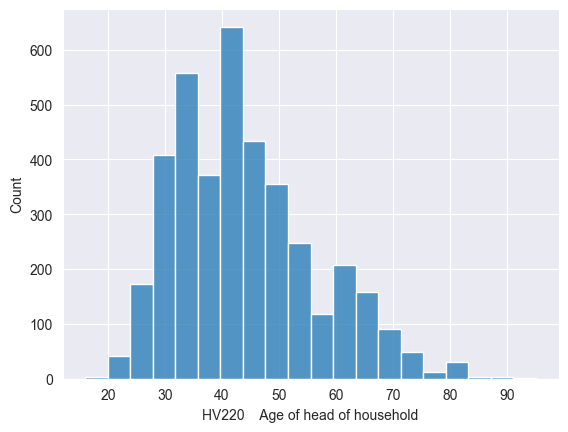

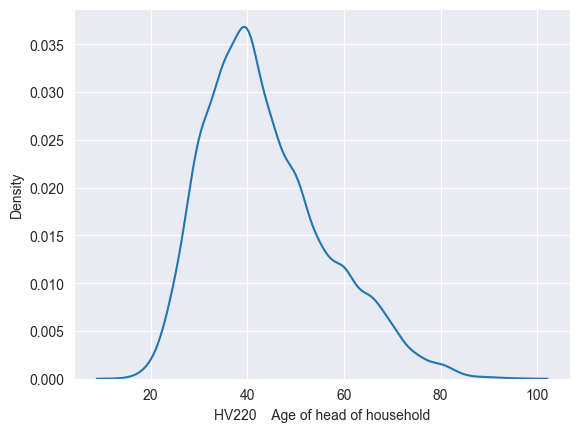

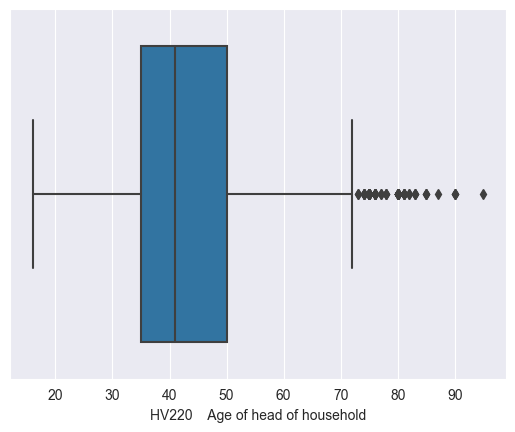

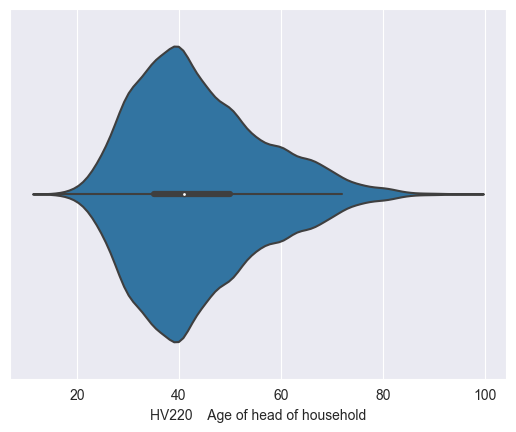

In [164]:
for col in _demographic_data:
    feature_uni_varaite_analysis(col, _demographic_data)

# Machine Learning

In [165]:
children_under_5[demographic_factors].head()

,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV219 Sex of head of household,HV220 Age of head of household
9,14.0,3.0,14.0,14.0,3.0,Male,50.0
10,14.0,3.0,14.0,14.0,3.0,Male,50.0
13,14.0,3.0,14.0,14.0,3.0,Male,50.0
21,6.0,2.0,6.0,6.0,1.0,Male,38.0
31,9.0,2.0,9.0,9.0,2.0,Male,41.0


In [166]:
demo_socio_data = children_under_5[sorted(set(demographic_factors + socio_economic_factors))]

In [167]:
demo_socio_data.head()

,HML1 Number of mosquito bed nets,HV004 Ultimate area unit,HV009 Number of household members,HV010 Number of eligible women in household,HV012 Number of de jure members,HV013 Number of de facto members,HV014 Number of children 5 and under (de jure),HV204 Time to get to water source (minutes),HV205 Type of toilet facility,HV206 Has electricity,...,HV246A Owns cattle,HV246B Owns cows bulls,HV246C Owns horses donkeys mules,HV246D Owns goats,HV246E Owns sheep,HV246F Owns chickenspoultry,HV246G Owns pigs,HV246H Owns camels,HV247 Has bank account,HV270 Wealth index combined
9,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
10,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
13,0.0,1.0,14.0,3.0,14.0,14.0,3.0,2.0,Flush to septic tank,Yes,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Yes,Richer
21,2.0,1.0,6.0,2.0,6.0,6.0,1.0,On premises,Flush to septic tank,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Middle
31,1.0,1.0,9.0,2.0,9.0,9.0,2.0,On premises,Flush to septic tank,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Middle


In [168]:
target = 'HML32$01 Final result of malaria from blood smear test'
demo_socio_data[target] = children_under_5[target]

In [169]:
print(demo_socio_data['HV220    Age of head of household'].dtypes)

float64


In [170]:
object_variables = demo_socio_data['HV220    Age of head of household'][
    demo_socio_data['HV220    Age of head of household'].apply(lambda x: isinstance(x, object))].unique()

print(len(object_variables))

71


In [171]:
demo_socio_data['HV220    Age of head of household'] = pd.to_numeric(
    demo_socio_data['HV220    Age of head of household'], errors='coerce')
demo_socio_data['HV238    Number of households sharing toilet'] = pd.to_numeric(
    demo_socio_data['HV238    Number of households sharing toilet'], errors='coerce')
demo_socio_data['HV245    Hectares of agricultural land (1 decimal)'] = pd.to_numeric(
    demo_socio_data['HV245    Hectares of agricultural land (1 decimal)'], errors='coerce')

In [172]:
label_encoder = LabelEncoder()
for column in demo_socio_data.select_dtypes(include=['object']).columns:
    demo_socio_data[column] = label_encoder.fit_transform(demo_socio_data[column])

In [173]:
demo_socio_data = demo_socio_data.fillna(demo_socio_data.mean())
demo_socio_data.isnull().sum()

HML1     Number of mosquito bed nets                                 0
HV004    Ultimate area unit                                          0
HV009    Number of household members                                 0
HV010    Number of eligible women in household                       0
HV012    Number of de jure members                                   0
HV013    Number of de facto members                                  0
HV014    Number of children 5 and under (de jure)                    0
HV204    Time to get to water source (minutes)                       0
HV205    Type of toilet facility                                     0
HV206    Has electricity                                             0
HV207    Has radio                                                   0
HV208    Has television                                              0
HV209    Has refrigerator                                            0
HV210    Has bicycle                                                 0
HV211 

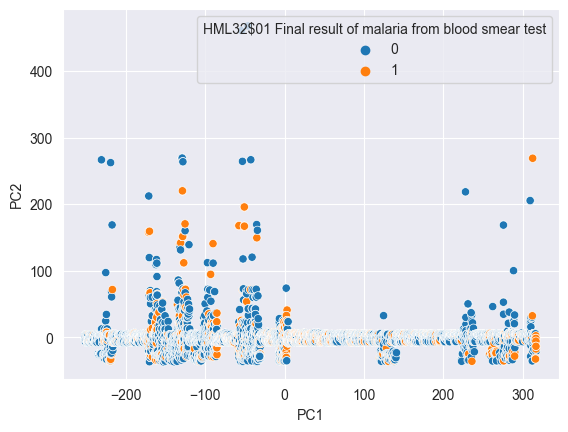

In [174]:

# Due to the large number of columns, exploratory data analysis is not easy. PCA is used to reduce the number of columns. inorder to perform EDA, the data is reduced to 2 dimensions using PCA.

# Split the data into features and labels
X = demo_socio_data.drop([target], axis=1)
y = demo_socio_data[target]

# Instantiate a PCA object and fit it to the data
pca = PCA(n_components=2)
pca.fit(X)

# Transform the data into 2D using the PCA object
X_2d = pca.transform(X)

# Plot the transformed data
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y)

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [175]:
new_data = demo_socio_data.__deepcopy__()
Y_data = new_data.pop(target)
X_data = new_data

Class Labels Index([0, 1], dtype='int64', name='HML32$01 Final result of malaria from blood smear test')
Class Counts [8390 2265]
Class Percentage [78.74237447 21.25762553]


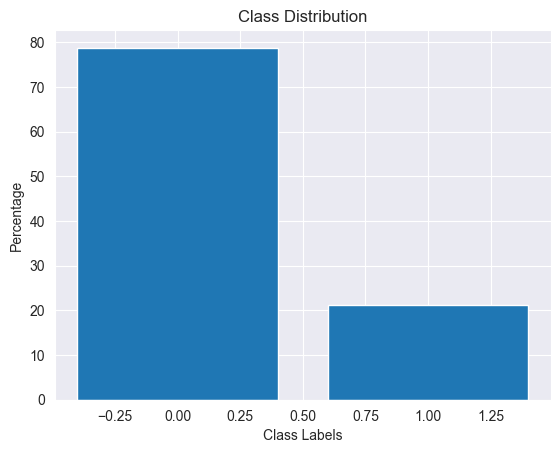

In [176]:
# Assuming your target variable is stored in a column called 'target'
target_counts = Y_data.value_counts()

# Calculate the class distribution
class_labels = target_counts.index
class_counts = target_counts.values
total_samples = len(new_data)

# Calculate the percentage of each class
class_percentages = (class_counts / total_samples) * 100
print('Class Labels', class_labels)
print('Class Counts', class_counts)
print('Class Percentage', class_percentages)

# Plotting the class distribution
plt.bar(class_labels, class_percentages)
plt.xlabel('Class Labels')
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.show()

In [177]:
def undersampling():
    # Perform undersampling
    undersampler = RandomUnderSampler(sampling_strategy='majority')
    return undersampler.fit_resample(X_data, Y_data)


def oversampling():
    # Perform oversampling
    oversampler = RandomOverSampler(sampling_strategy='minority')
    return oversampler.fit_resample(X_data, Y_data)


def smote():
    # Perform SMOTE
    smote_sampler = SMOTE(sampling_strategy='minority')
    return smote_sampler.fit_resample(X_data, Y_data)


classifier = LogisticRegression()
results = {}
for algorithm in [undersampling, oversampling, smote]:
    X, Y = algorithm()
    classifier.fit(X, Y)
    predicted_labels = classifier.predict(X_data)
    accuracy = accuracy_score(Y_data, predicted_labels)
    results[algorithm.__name__] = accuracy

# Determine the best algorithm based on the accuracy
best_algorithm = max(results, key=results.get)

# Print the results and the best algorithm
print("Sampling Algorithm Results:")
for algorithm, accuracy in results.items():
    print(f"{algorithm}: {accuracy}")
print("\nBest Algorithm:")
print(best_algorithm)

Sampling Algorithm Results:
undersampling: 0.5764429845143125
oversampling: 0.585452839042703
smote: 0.6330361332707649

Best Algorithm:
smote


In [178]:
X_data.columns

Index(['HML1     Number of mosquito bed nets', 'HV004    Ultimate area unit',
       'HV009    Number of household members',
       'HV010    Number of eligible women in household',
       'HV012    Number of de jure members',
       'HV013    Number of de facto members',
       'HV014    Number of children 5 and under (de jure)',
       'HV204    Time to get to water source (minutes)',
       'HV205    Type of toilet facility', 'HV206    Has electricity',
       'HV207    Has radio', 'HV208    Has television',
       'HV209    Has refrigerator', 'HV210    Has bicycle',
       'HV211    Has motorcyclescooter', 'HV212    Has cartruck',
       'HV213    Main floor material', 'HV214    Main wall material',
       'HV215    Main roof material',
       'HV216    Number of rooms used for sleeping',
       'HV219    Sex of head of household',
       'HV220    Age of head of household',
       'HV221    Has telephone (land-line)', 'HV222    Type of cookstove',
       'HV225    Share toilet wit

In [179]:
!pip install boruta

In [180]:
# def feature_selection(X, y):
#     from sklearn.ensemble import RandomForestClassifier
#     # define random forest classifier
#     forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#     forest.fit(X, y)
#     from boruta import BorutaPy
# 
#     # define Boruta feature selection method
#     feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)
# 
#     # find all relevant features
#     feat_selector.fit(X, y)
# 
#     # check selected features
#     feat_selector.support_
# 
#     # check ranking of features
#     feat_selector.ranking_
# 
#     return feat_selector

In [181]:
# br = BoostARoota(metric='logloss')
# br.fit(X_data, Y_data)
# # print('The number of features that are not correlated: ', br.transform(X_data).shape[1])
# # print('The number of features that are correlated: ', X_data.shape[1] - br.transform(X_data).shape[1])
# # print('The percentage of features that are not correlated: ', br.transform(X_data).shape[1] / X_data.shape[1])
# # print('The percentage of features that are correlated: ', 1 - br.transform(X_data).shape[1] / X_data.shape[1])
# # print('The features that are important: ', br.keep_vars_)

In [182]:
# X_data = feature_selection(X_data,Y_data).transform(X_data)
# # X_data = br.transform(X_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

In [183]:
class func():
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state

        assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'log'), 'Incorrect model_type'

    def __call__(self, plot=True):
        return self.fit(plot)

    def fit(self, plot):
        def log_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=500,
                           verbose=50, use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                             1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit=self.model.get_booster().best_ntree_limit)[
                              :, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                           1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration=self.model.best_iteration_)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration=self.model.best_iteration_)[:, 1]
            return x_test_predict, x_train_predict

        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits=splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train, X_test = self.train.iloc[train_index], self.train.iloc[test_index]
            y_train, y_test = self.label.iloc[train_index], self.label.iloc[test_index]

            print(f"================================Fold{fold_count + 1}====================================")
            if self.model_type == 'catboost':
                x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost':
                x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'log':
                x_test_predict, x_train_predict = log_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm':
                x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)
            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_train, x_train_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot and self.model_type != 'log':
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_, self.train.columns)),
                                    columns=['Value', 'Feature'])
            plt.figure(figsize=(30, 25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p / splits, self.model

In [184]:
func_ = func(X_train, y_train, X_test, classifier, 'log', 1000)
val_p, test_p, model = func_()

================================Fold1====================================

Validation scores 0.6912138742737451 0.47428902513405063
Training scores 0.6973970909083351 0.47235763179585155
================================Fold2====================================

Validation scores 0.6712777098970151 0.4832938435189823
Training scores 0.6905315270237199 0.4755574735096701
================================Fold3====================================

Validation scores 0.6725432012567638 0.48151430093970293
Training scores 0.682759989545809 0.4779190267010889
================================Fold4====================================

Validation scores 0.6939516162548105 0.47316502499151564
Training scores 0.6840542282578028 0.4783137877053701
================================Fold5====================================

Validation scores 0.6651673289954437 0.4954364737428303
Training scores 0.6966038362674446 0.4732716196835418
0.6902693344006223 0.6902693344006223 0.0060994651604980655


================================Fold1====================================
0:	learn: 0.6984739	test: 0.6981658	best: 0.6981658 (0)	total: 13.3ms	remaining: 2m 12s
50:	learn: 0.6981236	test: 0.6981658	best: 0.6981658 (0)	total: 235ms	remaining: 45.9s
100:	learn: 0.6981236	test: 0.6981658	best: 0.6981658 (0)	total: 350ms	remaining: 34.3s
150:	learn: 0.7021511	test: 0.6992717	best: 0.6995643 (141)	total: 463ms	remaining: 30.2s
200:	learn: 0.7057270	test: 0.6991790	best: 0.7006606 (152)	total: 578ms	remaining: 28.2s
250:	learn: 0.7109487	test: 0.7083038	best: 0.7086216 (242)	total: 693ms	remaining: 26.9s
300:	learn: 0.7121231	test: 0.7096264	best: 0.7096264 (298)	total: 807ms	remaining: 26s
350:	learn: 0.7146708	test: 0.7109434	best: 0.7109434 (326)	total: 922ms	remaining: 25.3s
400:	learn: 0.7180800	test: 0.7106198	best: 0.7109434 (326)	total: 1.04s	remaining: 24.9s
450:	learn: 0.7206534	test: 0.7119284	best: 0.7119284 (404)	total: 1.16s	remaining: 24.5s
500:	learn: 0.7228007	test: 0.71386

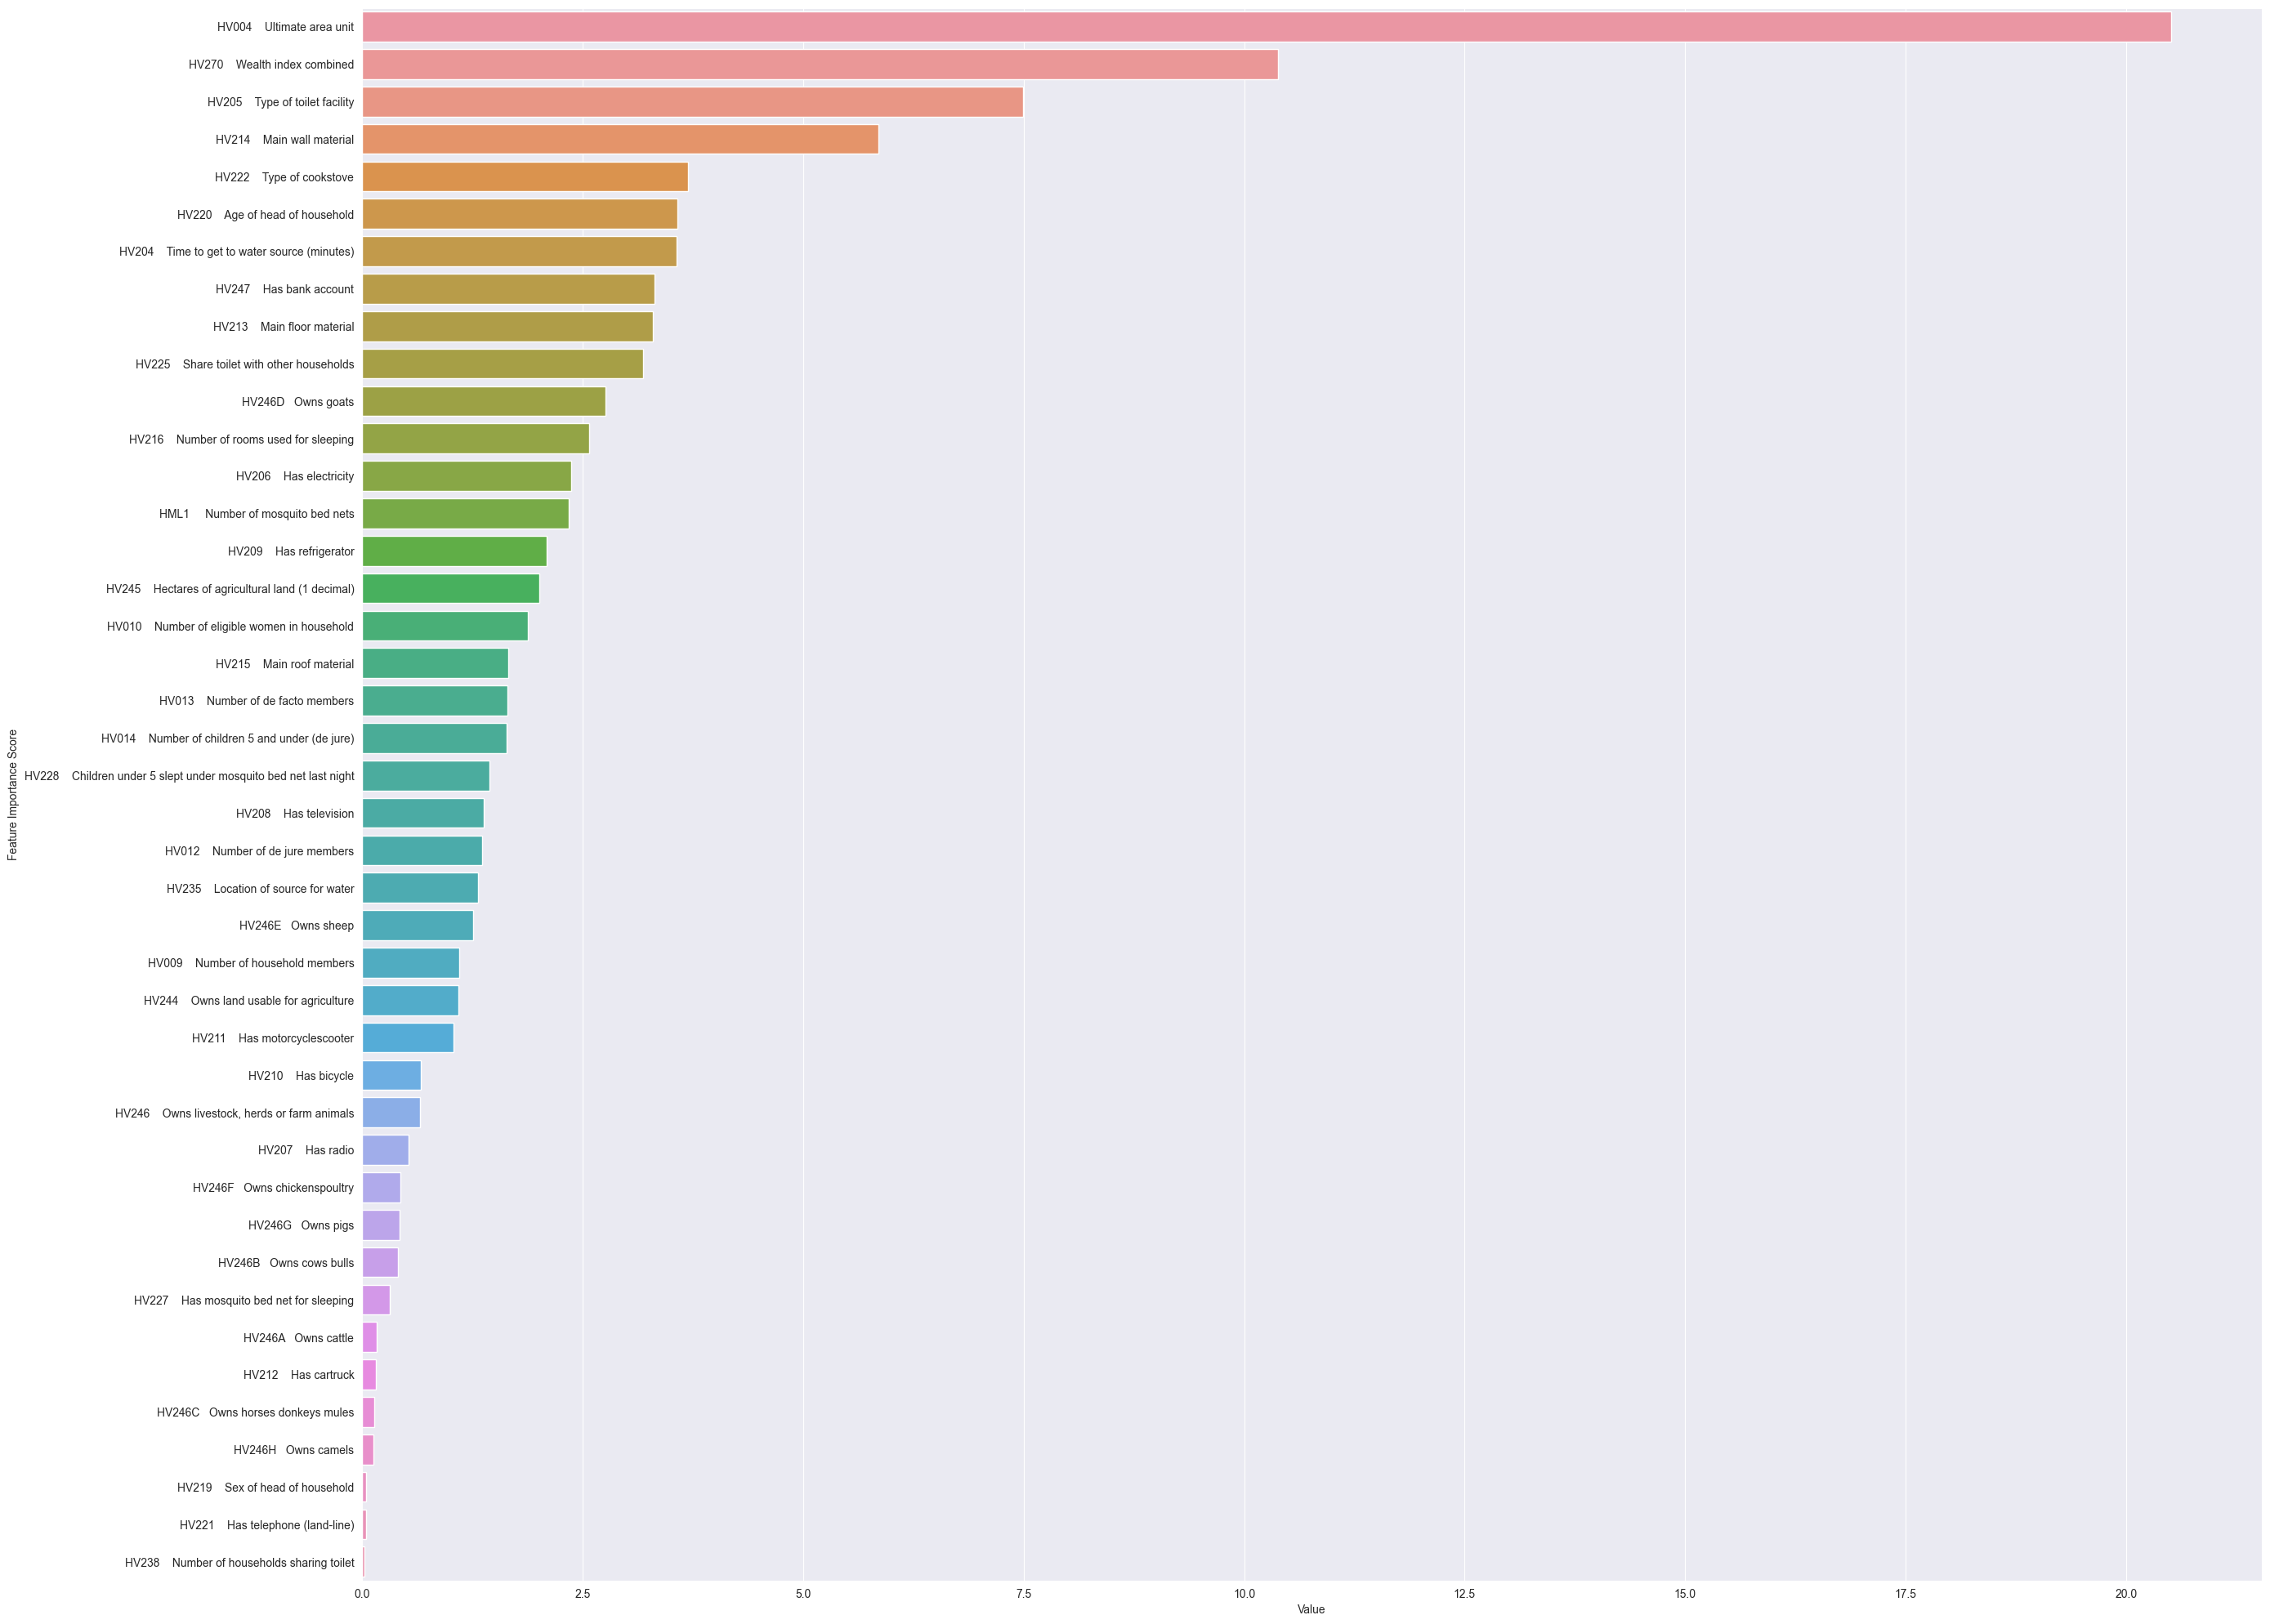

0.8357933882064843 0.8357933882064843 0.02580356187729592


In [185]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='TotalF1', reg_lambda=370)

func_ = func(X_train, y_train, X_test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

================================Fold1====================================
[11:55:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "objectsve", "scoring", "sub_sample" } are not used.

[0]	validation_0-auc:0.51030
[1]	validation_0-auc:0.62614
[2]	validation_0-auc:0.68563
[3]	validation_0-auc:0.70028
[4]	validation_0-auc:0.71568
[5]	validation_0-auc:0.72143
[6]	validation_0-auc:0.72392
[7]	validation_0-auc:0.72499
[8]	validation_0-auc:0.72466
[9]	validation_0-auc:0.72727
[10]	validation_0-auc:0.72716
[11]	validation_0-auc:0.72918
[12]	validation_0-auc:0.73021
[13]	validation_0-auc:0.73101
[14]	validation_0-auc:0.73229
[15]	validation_0-auc:0.73187
[16]	validation_0-auc:0.73161
[17]	validation_0-auc:0.73218
[18]	validation_0-auc:0.73128
[19]	validation_0-auc:0.73262
[20]	validation_0-auc:0.73225
[21]	validation_0-auc:0.73361
[22]	validation_0-auc:0.73343
[23]	validation_0-auc:0.73429
[24]	vali

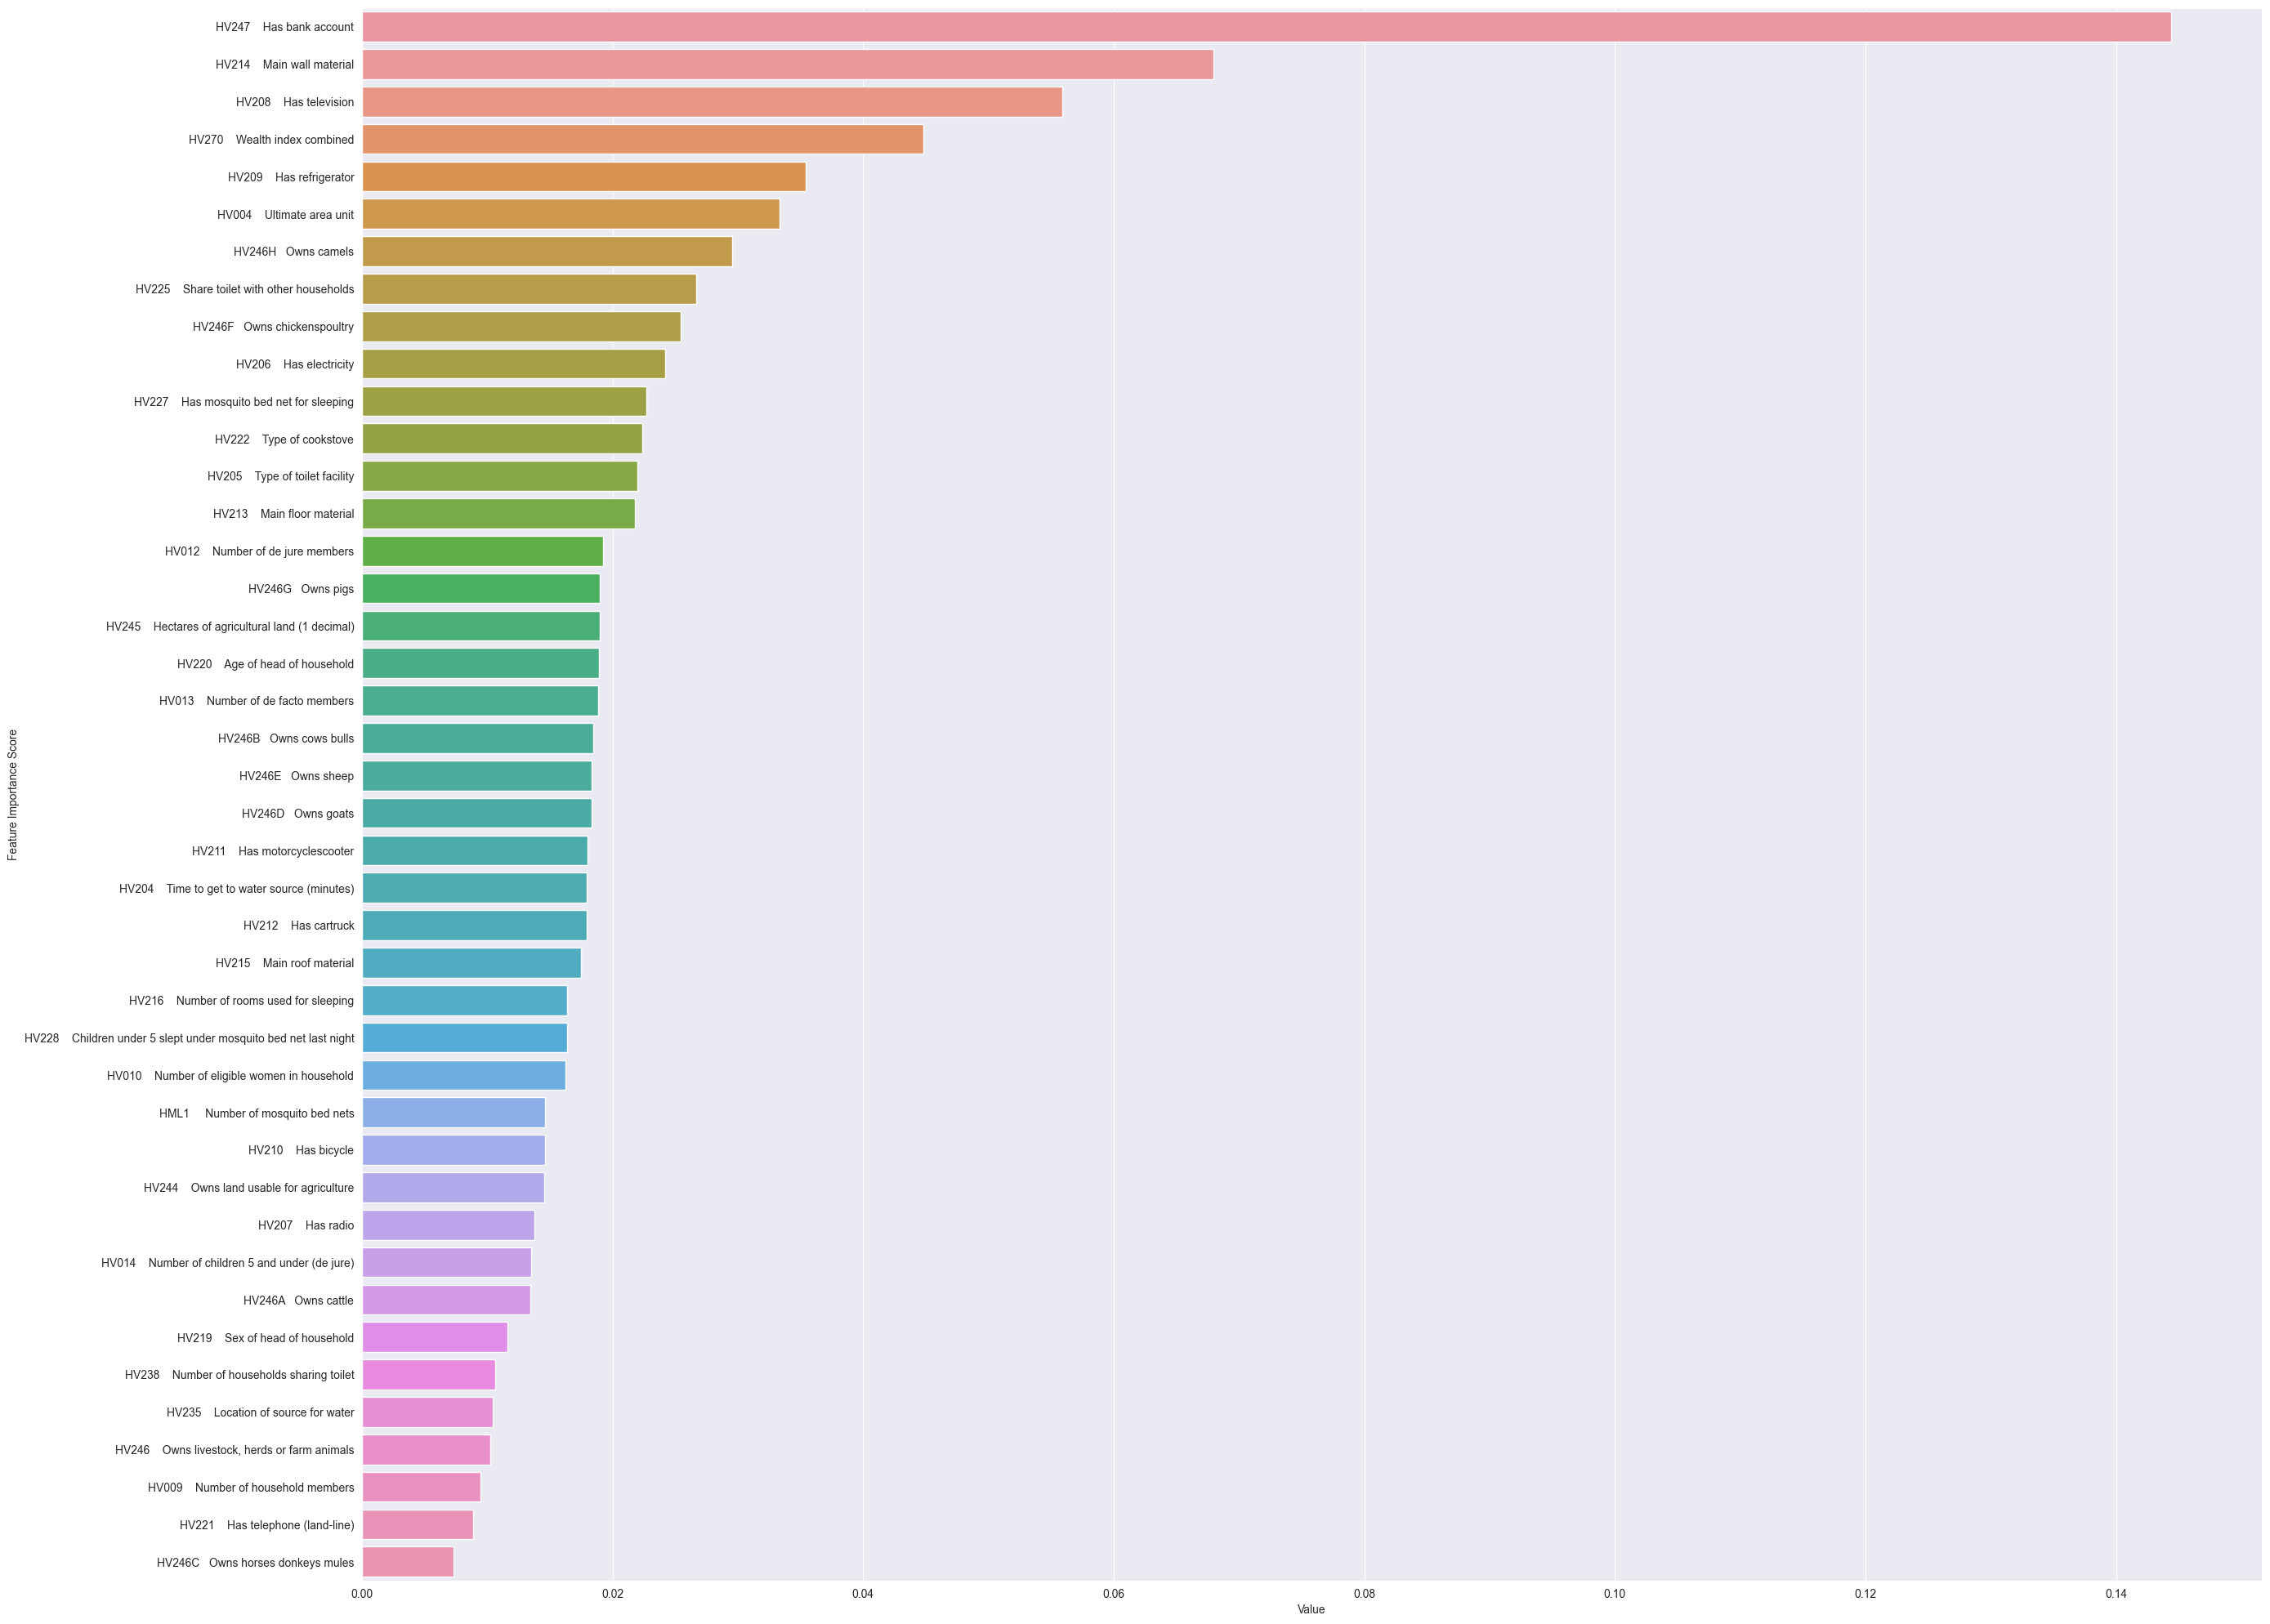

0.8477859781473847 0.8477859781473847 0.016718926975866973


In [186]:
xgboost = xgb.XGBClassifier(objectsve='binary:logistic',
                            eta=0.99,
                            max_depth=6,
                            n_estimators=5000,
                            reg_lambda=500,
                            scoring='f1',
                            sub_sample=0.8,
                            colsample_bytree=0.8)

func_ = func(X_train, y_train, X_test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

In [187]:
from subprocess import check_output
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
num_classes = 10
epochs = 20

In [188]:
X_train.shape

(8524, 42)

In [189]:
data_rows = X_train.shape[0]
data_cols = X_train.shape[1]
batch_size = 4096
data_shape = (data_rows,data_cols,1) 

In [190]:
data_shape

(8524, 42, 1)

In [199]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(324, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(512, activation='relu'))
NN_model.add(Dense(1024, activation='relu'))
NN_model.add(Dense(1024, activation='relu'))
NN_model.add(Dense(512, activation='relu'))
NN_model.add(Dense(256, activation='relu'))


NN_model.add(Flatten())


NN_model.add(Dense(4096, activation='relu'))
NN_model.add(Dropout(0.5))

NN_model.add(Dense(4096, activation='relu'))
NN_model.add(Dropout(0.5))

# The Output Layer :
NN_model.add(Dense(2, kernel_initializer='normal',activation='relu', kernel_regularizer = tf.keras.regularizers.l1(l=0.01) ))
# NN_model.add(Dense(1, kernel_initializer='normal',activation='linear', kernel_regularizer = tf.keras.regularizers.l1(l=0.01) ))

optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# Compile the network :
NN_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error', 'accuracy'])
# NN_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 324)               13932     
                                                                 
 dense_64 (Dense)            (None, 512)               166400    
                                                                 
 dense_65 (Dense)            (None, 1024)              525312    
                                                                 
 dense_66 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_67 (Dense)            (None, 512)               524800    
                                                                 
 dense_68 (Dense)            (None, 256)               131328    
                                                                 
 flatten_19 (Flatten)        (None, 256)             

In [200]:
NN_model.fit(X_train, y_train, epochs=3, batch_size=128, verbose=0)

In [201]:
results = NN_model.evaluate(X_test, y_test)

67/67 [==============================] - 1s 10ms/step - loss: 2.5134 - mean_absolute_error: 0.2252 - accuracy: 0.7748


In [193]:
aaaa= aka9 + 1

NameError: name 'aka9' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,auc,roc_curve


def evaluate_model(y_true, y_pred, average='binary'):
    """
    Function to evaluate a machine learning model's performance using common evaluation metrics and the classification report.

    Parameters:
        y_true (array-like): The true labels of the data.
        y_pred (array-like): The predicted labels of the data.
        average (str, optional): The type of averaging to use for multi-class classification.
                                 Can be 'binary', 'micro', 'macro', or 'weighted'. Default is 'binary'.
                                 Ignored for binary classification problems.

    Returns:
        dict: A dictionary containing the evaluation metrics and the centered classification report.
    """

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    # Calculate classification report
    report = classification_report(y_true, y_pred)
    print('Classification Report')
    print(report)

    # Create dictionary of evaluation metrics and centered classification report
    metrics = {'accuracy': accuracy,
               'precision': precision,
               'recall': recall,
               'f1': f1}
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Class 0', 'Class 1']
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    print('Metrics for the  Evaluation is',metrics)
    return metrics


In [ ]:
catboost_result = evaluate_model(y_test, model1.predict(X_test))


In [ ]:
xgboost_result = evaluate_model(y_test, model2.predict(X_test))

In [ ]:
logistic_regression_result = evaluate_model(y_test, model.predict(X_test))

In [ ]:
accuracy_list = [catboost_result['accuracy'], xgboost_result['accuracy'], logistic_regression_result['accuracy']]
precision_list = [catboost_result['precision'], xgboost_result['precision'], logistic_regression_result['precision']]
recall_list = [catboost_result['recall'], xgboost_result['recall'], logistic_regression_result['recall']]
f1_list = [catboost_result['f1'], xgboost_result['f1'], logistic_regression_result['f1']]

# Calculate percentages for accuracy list
total_accuracy = sum(accuracy_list)
accuracy_percentages = [round((accuracy / total_accuracy) * 100, 2) for accuracy in accuracy_list]

# Calculate percentages for precision list
total_precision = sum(precision_list)
precision_percentages = [round((precision / total_precision) * 100, 2) for precision in precision_list]

# Calculate percentages for recall list
total_recall = sum(recall_list)
recall_percentages = [round((recall / total_recall) * 100, 2) for recall in recall_list]

# Calculate percentages for f1 list
total_f1 = sum(f1_list)
f1_percentages = [round((f1 / total_f1) * 100, 2) for f1 in f1_list]

# Set colors for the bars
colors = ['#FFC107', '#FF5722', '#4CAF50']

# Plot for accuracy list with percentages
plt.figure(figsize=(12, 6))
plt.bar(['Catboost', 'XGBoost', 'Logistic Regression'], accuracy_list, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of different models')

# Add percentage labels to the bars
for i, accuracy in enumerate(accuracy_list):
    plt.text(i, accuracy + 0.5, f"{accuracy_percentages[i]}%", ha='center')

plt.show()

# Plot for precision list with percentages
plt.figure(figsize=(12, 6))
plt.bar(['Catboost', 'XGBoost', 'Logistic Regression'], precision_list, color=colors)
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision of different models')

# Add percentage labels to the bars
for i, precision in enumerate(precision_list):
    plt.text(i, precision + 0.01, f"{precision_percentages[i]}%", ha='center')

plt.show()

# Plot for recall list with percentages
plt.figure(figsize=(12, 6))
plt.bar(['Catboost', 'XGBoost', 'Logistic Regression'], recall_list, color=colors)
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall of different models')

# Add percentage labels to the bars
for i, recall in enumerate(recall_list):
    plt.text(i, recall + 0.01, f"{recall_percentages[i]}%", ha='center')

plt.show()

# Plot for f1 list with percentages
plt.figure(figsize=(12, 6))
plt.bar(['Catboost', 'XGBoost', 'Logistic Regression'], f1_list, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score of different models')

# Add percentage labels to the bars
for i, f1 in enumerate(f1_list):
    plt.text(i, f1 + 0.01, f"{f1_percentages[i]}%", ha='center')

plt.show()